# Data Setup

In [ ]:
#@title Libraries
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
from jax import vmap, grad
import jax.random as jr
import time
import tqdm
from sklearn.decomposition import PCA
import optax
import plotly.express as px
from sklearn.manifold import TSNE

import array
import gzip
import os
from os import path
import struct
import urllib.request

In [ ]:
#@title Data Imports
#source: https://github.com/google/jax/blob/main/examples/datasets.py
_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print(f"downloaded {url} to {_DATA}")

def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return np.array(array.array("B", fh.read()), dtype=np.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return np.array(array.array("B", fh.read()),
                      dtype=np.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels

x_raw, x_lab, x_test_raw, x_test_lab = mnist_raw()
# Scale the data so it's from 0 to 1
x = x_raw / 255
x_test = x_test_raw / 255

downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz to /tmp/jax_example_data/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz to /tmp/jax_example_data/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz to /tmp/jax_example_data/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz to /tmp/jax_example_data/


In [ ]:
#@title Turn Labels Into One-Hot Encodings

x_lab_hot = []
for i in range(len(x_lab)):
  x_lab_hot.append(jax.nn.one_hot(x_lab[i], 10))

x_lab_hot = jnp.array(x_lab_hot)

x_test_lab_hot = []
for i in range(len(x_test_lab)):
  x_test_lab_hot.append(jax.nn.one_hot(x_test_lab[i], 10))

x_test_lab_hot = jnp.array(x_test_lab_hot)

In [ ]:
#@title Batching and Flattening

#flatten into 784-d vectors
x = jnp.reshape(x, (60000, 784))
print(x.shape)

x_test = jnp.reshape(x_test, (10000, 784))
print(x_test.shape)

#batching
x_batched = jnp.array_split(x, 1875)
print(x_batched[0].shape)

x_lab_batched = jnp.array_split(x_lab_hot, 1875)
print(x_lab_batched[0])

(60000, 784)
(10000, 784)
(32, 784)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0.

# Linear & Nonlinear AE

In [ ]:
#@title Parameter Initialization and Loss Function
latent_dim = 10
data_dim = 784

def initialize(latent_dim):
  W_1 = jr.normal(jr.PRNGKey(0), (data_dim, latent_dim))
  b_1 = jr.normal(jr.PRNGKey(1), (latent_dim,))
  W_2 = jr.normal(jr.PRNGKey(2), (latent_dim, data_dim))
  b_2 = jr.normal(jr.PRNGKey(3), (data_dim,))
  return([W_1, b_1, W_2, b_2])

def initialize_nl(latent_dim, neur_dim):
  #encoding
  W_1 = jr.normal(jr.PRNGKey(0), (data_dim, neur_dim)) / neur_dim
  b_1 = jr.normal(jr.PRNGKey(1), (neur_dim,))
  W_2 = jr.normal(jr.PRNGKey(2), (neur_dim, latent_dim)) / neur_dim
  b_2 = jr.normal(jr.PRNGKey(3), (latent_dim,))

  #decoding
  W_3 = jr.normal(jr.PRNGKey(4), (latent_dim, neur_dim)) / neur_dim
  b_3 = jr.normal(jr.PRNGKey(5), (neur_dim,))
  W_4 = jr.normal(jr.PRNGKey(6), (neur_dim, data_dim)) / neur_dim
  b_4 = jr.normal(jr.PRNGKey(7), (data_dim,))
  return([W_1, b_1, W_2, b_2, W_3, b_3, W_4, b_4])

#W_1 = jr.normal(jr.PRNGKey(0), (data_dim, latent_dim))
#b_1 = jr.normal(jr.PRNGKey(1), (latent_dim,))
#W_2 = jr.normal(jr.PRNGKey(2), (latent_dim, 784))
#b_2 = jr.normal(jr.PRNGKey(3), (data_dim,))

#theta = [W_1, b_1, W_2, b_2]

theta = initialize(latent_dim)

# linear loss function w/ vmap
def loss(data, params):
  def transform(data):
    z = data @ params[0] + params[1]
    x_hat = z @ params[2] + params[3]
    return x_hat
  x_hat = vmap(transform)(data)
  return jnp.mean((data - x_hat) ** 2)

# non-linear loss function w/ vmap
def nonlin_loss_relu(data, params):
  def nonlin_transform_relu(data):
    z1 = jax.nn.relu(data @ params[0] + params[1])
    z = z1 @ params[2] + params[3]
    z2 = jax.nn.relu(z @ params[4] + params[5])
    x_hat = jax.nn.tanh(z2 @ params[6] + params[7])
    return x_hat
  x_hat = vmap(nonlin_transform_relu)(data)
  return jnp.mean((data - x_hat) ** 2)

'''
def nonlin_loss_tanh(data, params):
  def nonlin_transform_tanh(data):
    z = jax.nn.tanh(data @ params[0]) + params[1]
    x_hat = jax.nn.tanh(z @ params[2]) + params[3]
    return x_hat
  x_hat = vmap(nonlin_transform_tanh)(data)
  return jnp.mean((data - x_hat) ** 2)
'''

'\ndef nonlin_loss_tanh(data, params):\n  def nonlin_transform_tanh(data):\n    z = jax.nn.tanh(data @ params[0]) + params[1]\n    x_hat = jax.nn.tanh(z @ params[2]) + params[3]\n    return x_hat\n  x_hat = vmap(nonlin_transform_tanh)(data)\n  return jnp.mean((data - x_hat) ** 2)\n'

In [ ]:
#@title Shape Testing

W_1 = jr.normal(jr.PRNGKey(0), (data_dim, latent_dim))
b_1 = jr.normal(jr.PRNGKey(1), (latent_dim,))
W_2 = jr.normal(jr.PRNGKey(2), (latent_dim, 784))
b_2 = jr.normal(jr.PRNGKey(3), (data_dim,))

theta = [W_1, b_1, W_2, b_2]

print(x.shape,W_1.shape,b_1.shape)

z = jax.nn.relu(x @ W_1) + b_1

print(z.shape,W_2.shape,b_2.shape)

x_hat = jax.nn.relu(z @ W_2) + b_2

print(z.shape,x_hat.shape)

(60000, 784) (784, 10) (10,)
(60000, 10) (10, 784) (784,)
(60000, 10) (60000, 784)


In [ ]:
#@title Training

theta = initialize(10)

print(f"intial loss (random initialization): {loss(x, theta)}")

#linear traning
def train_step(data, params, lr):
  def l(params):
    return loss(data, params)

  g = grad(l)(params)

  for i in range(len(params)):
    params[i] -= g[i] * lr

  return params

train_step_jit = jax.jit(train_step)

#non-linear traning - relu
def nonlin_train_step_relu(data, params, lr):
  def l(params):
    return nonlin_loss_relu(data, params)

  g = grad(l)(params)

  for i in range(len(params)):
    params[i] -= g[i] * lr

  return params

nonlin_train_step_relu_jit = jax.jit(nonlin_train_step_relu)

'''
def nonlin_train_step_tanh(data, params, lr):
  def l(params):
    return nonlin_loss_tanh(data, params)

  g = grad(l)(params)

  for i in range(len(params)):
    params[i] -= g[i] * lr

  return params

nonlin_train_step_tanh_jit = jax.jit(nonlin_train_step_tanh)
'''

intial loss (random initialization): 1030.0816650390625


'\ndef nonlin_train_step_tanh(data, params, lr):\n  def l(params):\n    return nonlin_loss_tanh(data, params)\n\n  g = grad(l)(params)\n\n  for i in range(len(params)):\n    params[i] -= g[i] * lr\n\n  return params\n\nnonlin_train_step_tanh_jit = jax.jit(nonlin_train_step_tanh)\n'

In [ ]:
#@title Plotting Functions

def plot_steps_loss(n_dim, n_steps, lr, col, lab):
  theta = initialize(n_dim)
  losses = []
  for i in range(n_steps):
    for j in range(len(x_batched)):
      theta = train_step_jit(x_batched[j],theta,lr)
    losses.append(loss(x,theta))
  plt.plot([k for k in range(n_steps)], losses, color = col, marker = 'o', label = lab)
  return theta, losses

def nonlin_plot_steps_loss_relu(latent_dim, n_steps, lr, neur_dim, col, lab):
  theta = initialize_nl(latent_dim, neur_dim)
  losses = []
  for i in range(n_steps):
    for j in range(len(x_batched)):
      theta = nonlin_train_step_relu_jit(x_batched[j],theta,lr)
    losses.append(nonlin_loss_relu(x,theta))
  plt.plot([k for k in range(n_steps)], losses, color = col, marker = 'o', label = lab)
  return theta, losses
'''
def nonlin_plot_steps_loss_tanh(n_dim, n_steps, lr, col, lab):
  theta = initialize(n_dim)
  losses = []
  for i in range(n_steps):
    for j in range(len(x_batched)):
      theta = nonlin_train_step_tanh_jit(x_batched[j],theta,lr)
    losses.append(nonlin_loss_tanh(x,theta))
  plt.plot([k for k in range(n_steps)], losses, color = col, marker = 'o', label = lab)
  return theta, losses
'''

"\ndef nonlin_plot_steps_loss_tanh(n_dim, n_steps, lr, col, lab):\n  theta = initialize(n_dim)\n  losses = []\n  for i in range(n_steps):\n    for j in range(len(x_batched)):\n      theta = nonlin_train_step_tanh_jit(x_batched[j],theta,lr)\n    losses.append(nonlin_loss_tanh(x,theta))\n  plt.plot([k for k in range(n_steps)], losses, color = col, marker = 'o', label = lab)\n  return theta, losses\n"

In [ ]:
#@title Progress Bar
bar = tqdm.trange(100)
for i in bar:
    pass

In [ ]:
#@title Timing jit vs. non-jit training functions

# timing for non jit training function - 10 steps
t0 = time.time()
for i in range(10):
  theta = train_step(x,theta,0.0001)
t1 = time.time()
print(f"non-jit time: {t1 - t0}")

# timing for jit train function - 10 steps
t0 = time.time()
for i in range(10):
  theta = train_step_jit(x,theta,0.0001)
t1 = time.time()
print(f"jit time: {t1 - t0}")

non-jit time: 20.077202320098877
jit time: 6.219285488128662


# 2d and 3d Latent Representations

In [ ]:
#@title 2d Representation
theta_2d = initialize(2)

n_steps = 500
lr = 0.03

for i in range(n_steps):
  for j in range(len(x_batched)):
    theta_2d = train_step_jit(x_batched[j],theta_2d,lr)

print(loss(x, theta_2d))

z = x @ theta_2d[0] + theta_2d[1]

colors = ['red','orange','yellow','green','blue','indigo','violet','purple','pink','brown']

0.058374837


In [ ]:
#@title Sorting Data by Digit
def select_digit(n,rang):
  arr = []
  z = x @ theta[0] + theta[1]
  for i in range(rang):
    if (x_lab[i] == n):
      arr.append(z[i])
  return arr

sorted_digits = []
rang = 10000
for i in range(10):
  sorted_digits.append(select_digit(i,rang))

print(sorted_digits[0][0])

NameError: ignored

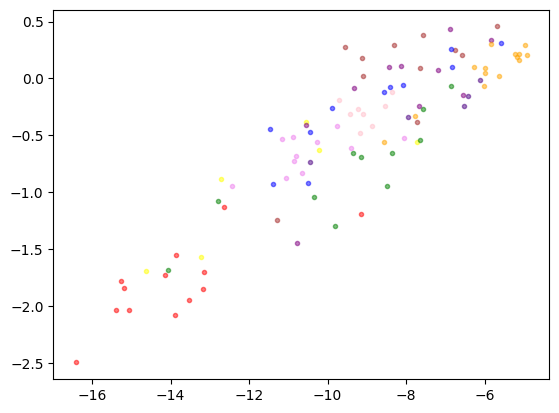

In [ ]:
#@title Representation in 2d Latent Space - All Digits
for i in range(100):
  plt.scatter(z[i, 0], z[i, 1], marker = '.', alpha = 0.5, color = colors[x_lab[i]])

plt.show()

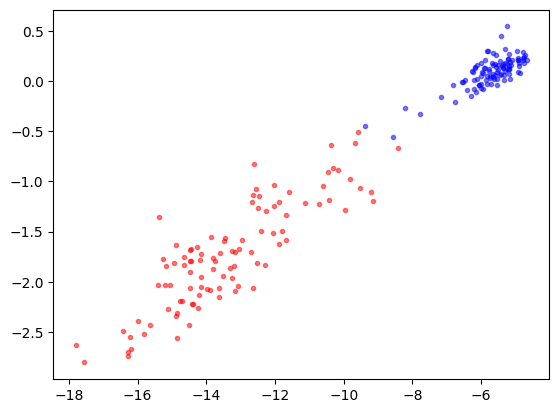

In [ ]:
#@title Representation in 2d Latent Space - 0s vs. 1s
for i in range(100):
  plt.scatter(zeroes[i][0], zeroes[i][1], marker = '.', alpha = 0.5, color = 'red')
  plt.scatter(ones[i][0], ones[i][1], marker = '.', alpha = 0.5, color = 'blue')

plt.legend(["zero", "one"])
plt.show()

KeyboardInterrupt: ignored

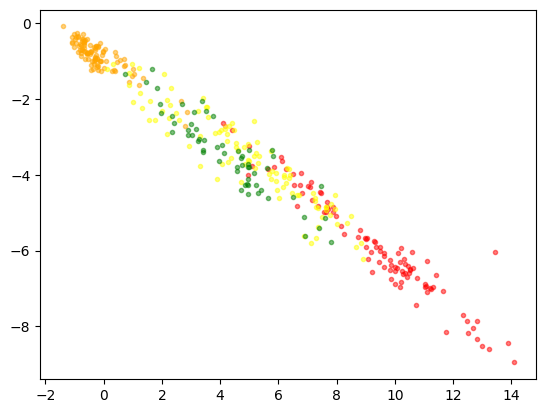

In [ ]:
#@title Representation in 2d Latent Space - #1-4
for i in range(4):
  for j in range(100):
    plt.scatter(sorted_digits[i][j][0], sorted_digits[i][j][1], marker = '.', alpha = 0.5, color = colors[i])


labels = [f"{i}" for i in range(4)]

plt.legend(labels)
plt.show()

In [ ]:
#@title 3d Representation
theta_3d = initialize(3)

n_steps = 500
lr = 0.03

for i in range(n_steps):
  for j in range(len(x_batched)):
    theta_3d = train_step_jit(x_batched[j],theta_3d,lr)

print(loss(x, theta_3d))

z = x @ theta_3d[0] + theta_3d[1]

colors = ['red','orange','yellow','green','blue','indigo','violet','purple','pink','brown']

0.055210583


In [ ]:
#@title Representation in 3d Latent Space - 0s vs. 1s
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(2):
  for j in range(100):
    ax.scatter(sorted_digits[i][j][0], sorted_digits[i][j][1], sorted_digits[i][j][2], marker = '.', alpha = 0.5, color = colors[i])


labels = [f"{i}" for i in range(2)]

plt.legend(labels, color = colors)
plt.show()

NameError: ignored

# Linear & Nonlinear AE Loss Curves

In [ ]:
#@title Loss Curve - Linear vs. Nonlinear AE

plt.figure()

latent_dim = 10
neur_dim = 50
n_steps = 10
lr = 0.03

l_theta, l_losses = plot_steps_loss(latent_dim, n_steps, lr, 'red', 'linear')
n_theta, n_losses = nonlin_plot_steps_loss_relu(latent_dim, n_steps, lr, neur_dim, 'blue', 'non-linear')

plt.legend()
plt.show()

KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>

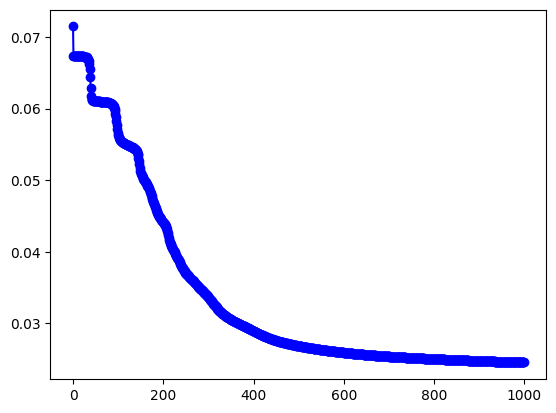

Minimum Loss: 0.0245448499917984


In [ ]:
#@title Loss Curve - Nonlinear AE
plt.figure()

n_dim = 10
n_steps = 1000
lr = 0.05
neur_dim = 100

n_theta, n_losses = nonlin_plot_steps_loss_relu(n_dim, n_steps, lr, neur_dim, 'blue', '')

plt.show()
print(f"Minimum Loss: {n_losses[-1]}")

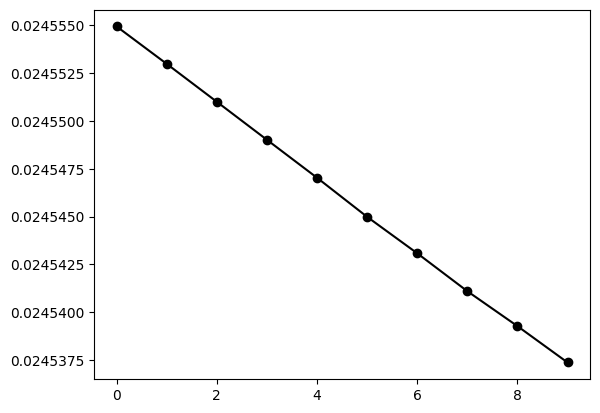

In [ ]:
#@title Has the function converged?
end_losses = n_losses[-10:]

plt.plot(end_losses, color = 'k', marker = 'o')

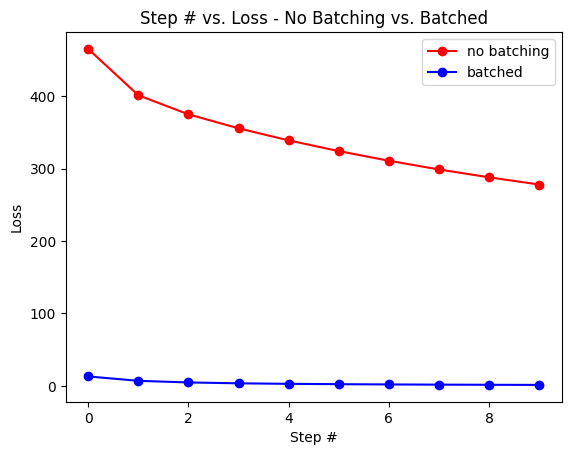

No Batching Time: 14.78401s, Batching Time: 12.97605s


In [ ]:
#@title Loss Curve - 10D, No Batching

latent_dim = 10
n_steps = 10
lr = 0.01

theta = initialize(latent_dim)

plt.figure()
plt.title("Step # vs. Loss - No Batching vs. Batched")
plt.xlabel("Step #")
plt.ylabel("Loss")
t0 = time.time()

losses = []
for i in range(n_steps):
  theta = train_step_jit(x,theta,lr)
  losses.append(loss(x,theta))
plt.plot([j for j in range(n_steps)], losses, color = 'red', marker = 'o', label = 'no batching')
t1 = time.time()

t2 = time.time()

plot_steps_loss(latent_dim,n_steps,lr,'blue','batched')

t3 = time.time()

plt.legend()
plt.show()
print(f"No Batching Time: {(t1 - t0):.5f}s, Batching Time: {(t3 - t2):.5f}s")

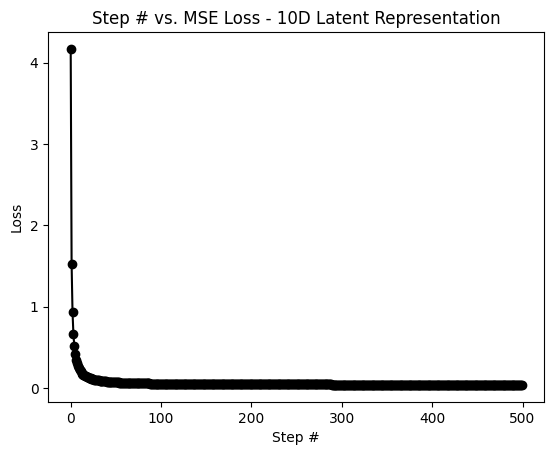

minimum loss: 0.04000289365649223


In [ ]:
#@title Loss Curve - 10D, Batched

latent_dim = 10
n_steps = 500
lr = 0.03

theta = initialize(10)

plt.figure()
plt.title("Step # vs. MSE Loss - 10D Latent Representation")
plt.xlabel("Step #")
plt.ylabel("Loss")

l_theta, l_losses = plot_steps_loss(latent_dim, n_steps, lr, 'k', '')

plt.show()

print(f"minimum loss: {l_losses[-1]}")

minimum loss: 98.31623077392578


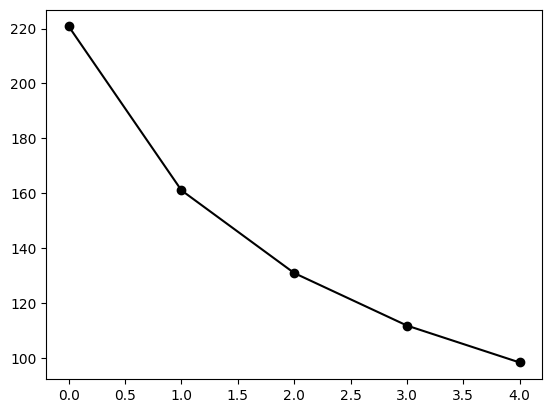

In [ ]:
#@title Has the Model Converged?
print(f"minimum loss: {losses[-1]}")
end_losses = losses[-50:]

plt.plot(end_losses, color = 'k', marker = 'o')
#plt.plot([k for k in range(n_steps-50, n_steps)], end_losses, color = 'k', marker = 'o')

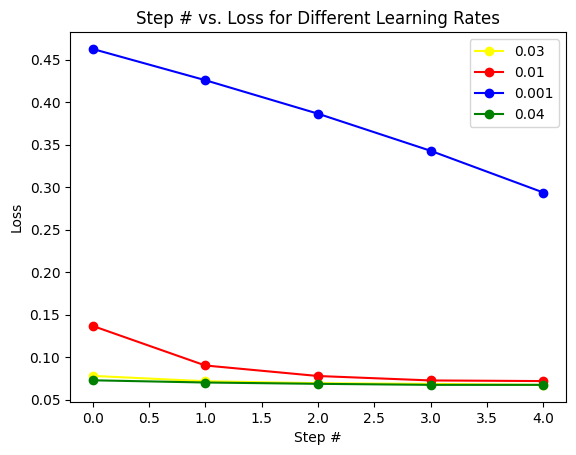

In [ ]:
#@title Loss Curve - Nonlinear Learning Rate Comparisons

latent_dim = 10
n_steps = 5

plt.figure()
plt.title("Step # vs. Loss for Different Learning Rates")
plt.xlabel("Step #")
plt.ylabel("Loss")

#lr of 0.03
lr = 0.03

nonlin_plot_steps_loss_relu(latent_dim, n_steps, lr, 50, 'yellow', f"{lr}")

#lr of 0.01
lr = 0.01

nonlin_plot_steps_loss_relu(latent_dim, n_steps, lr, 50, 'red', f"{lr}")

#lr of 0.001
lr = 0.001

nonlin_plot_steps_loss_relu(latent_dim, n_steps, lr, 50, 'blue', f"{lr}")

#lr of 0.0001
lr = 0.04

nonlin_plot_steps_loss_relu(latent_dim, n_steps, lr, 50, 'green', f"{lr}")

plt.legend()
plt.show()

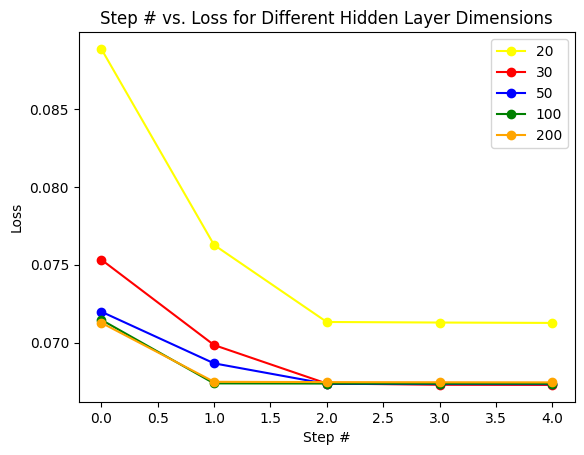

In [ ]:
#@title Loss Curve - Nonlinear Hidden Layer Dimensions Comparisons

latent_dim = 10
n_steps = 5
lr = 0.05

plt.figure()
plt.title("Step # vs. Loss for Different Hidden Layer Dimensions")
plt.xlabel("Step #")
plt.ylabel("Loss")

#neur_dim of 20
neur_dim = 20

nonlin_plot_steps_loss_relu(latent_dim, n_steps, lr, neur_dim, 'yellow', f"{neur_dim}")

#neur_dim of 20
neur_dim = 30

nonlin_plot_steps_loss_relu(latent_dim, n_steps, lr, neur_dim, 'red', f"{neur_dim}")

#neur_dim of 20
neur_dim = 50

nonlin_plot_steps_loss_relu(latent_dim, n_steps, lr, neur_dim, 'blue', f"{neur_dim}")

#neur_dim of 20
neur_dim = 100

nonlin_plot_steps_loss_relu(latent_dim, n_steps, lr, neur_dim, 'green', f"{neur_dim}")

#neur_dim of 20
neur_dim = 200

nonlin_plot_steps_loss_relu(latent_dim, n_steps, lr, neur_dim, 'orange', f"{neur_dim}")

plt.legend()
plt.show()

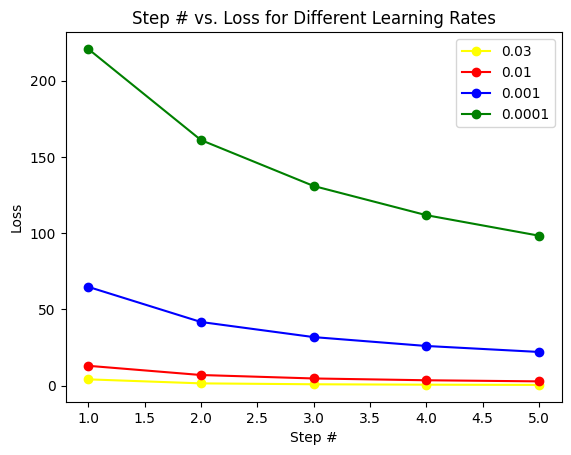

In [ ]:
#@title Loss Curve - Linear Learning Rate Comparisons

latent_dim = 10
n_steps = 5

#lr of 0.03
lr = 0.03

#initialize
theta = initialize(10)

plt.figure()
plt.title("Step # vs. Loss for Different Learning Rates")
plt.xlabel("Step #")
plt.ylabel("Loss")

losses = []
for i in range(n_steps):
  for j in range(len(x_batched)):
    theta = train_step_jit(x_batched[j],theta,lr)
  losses.append(loss(x,theta))
plt.plot([k for k in range(1, n_steps + 1)], losses, color = 'yellow', marker = 'o', label = '0.03')

#lr of 0.01
lr = 0.01

#re-initialize
theta = initialize(10)

losses = []
for i in range(n_steps):
  for j in range(len(x_batched)):
    theta = train_step_jit(x_batched[j],theta,lr)
  losses.append(loss(x,theta))
plt.plot([k for k in range(1, n_steps + 1)], losses, color = 'red', marker = 'o', label = '0.01')

#lr of 0.001
lr = 0.001

#re-initialize
theta = initialize(10)

losses = []
for i in range(n_steps):
  for j in range(len(x_batched)):
    theta = train_step_jit(x_batched[j],theta,lr)
  losses.append(loss(x,theta))
plt.plot([k for k in range(1, n_steps + 1)], losses, color = 'blue', marker = 'o', label = '0.001')

#lr of 0.0001
lr = 0.0001

#re-initialize
theta = initialize(10)

losses = []
for i in range(n_steps):
  for j in range(len(x_batched)):
    theta = train_step_jit(x_batched[j],theta,lr)
  losses.append(loss(x,theta))
plt.plot([k for k in range(1, n_steps + 1)], losses, color = 'green', marker = 'o', label = '0.0001')

plt.legend()
plt.show()

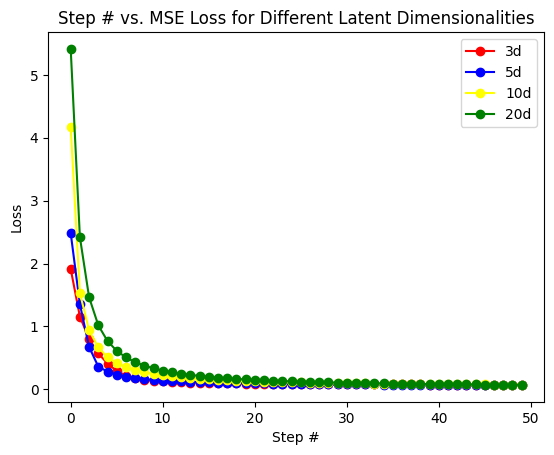

Final Losses After 50 Steps: 3d = [Array(1.914336, dtype=float32), Array(1.1547165, dtype=float32), Array(0.8016401, dtype=float32), Array(0.5729334, dtype=float32), Array(0.4082865, dtype=float32), Array(0.29226103, dtype=float32), Array(0.21773553, dtype=float32), Array(0.17388618, dtype=float32), Array(0.14883325, dtype=float32), Array(0.13393027, dtype=float32), Array(0.12425463, dtype=float32), Array(0.11733788, dtype=float32), Array(0.11199933, dtype=float32), Array(0.10766539, dtype=float32), Array(0.10403722, dtype=float32), Array(0.10094155, dtype=float32), Array(0.09826611, dtype=float32), Array(0.09593144, dtype=float32), Array(0.09387802, dtype=float32), Array(0.09205963, dtype=float32), Array(0.0904396, dtype=float32), Array(0.08898845, dtype=float32), Array(0.08768208, dtype=float32), Array(0.08650077, dtype=float32), Array(0.08542808, dtype=float32), Array(0.0844503, dtype=float32), Array(0.08355589, dtype=float32), Array(0.08273504, dtype=float32), Array(0.08197939, dty

In [ ]:
#@title Loss Curve - # of Latent Dimensions Comparison

plt.figure()

plt.title("Step # vs. MSE Loss for Different Latent Dimensionalities")
plt.xlabel("Step #")
plt.ylabel("Loss")

n_dim = 3
n_steps = 50
lr = 0.03
theta3, losses3 = plot_steps_loss(n_dim,n_steps,lr, 'red', f"{n_dim}d")

n_dim = 5
theta5, losses5 = plot_steps_loss(n_dim,n_steps,lr, 'blue', f"{n_dim}d")

n_dim = 10
theta10, losses10 = plot_steps_loss(n_dim,n_steps,lr, 'yellow', f"{n_dim}d")

n_dim = 20
theta20, losses20 = plot_steps_loss(n_dim,n_steps,lr, 'green', f"{n_dim}d")

plt.legend()
plt.show()

print(f"Final Losses After {n_steps} Steps: 3d = {losses3[-1]}, 5d = {losses5[-1]}, 10d = {losses10[-1]}, 20d = {losses20[-1]}")

In [ ]:
print(f"Final Losses After {n_steps} Steps: 3d = {losses3[-1]}, 5d = {losses5[-1]}, 10d = {losses10[-1]}, 20d = {losses20[-1]}")

Final Losses After 50 Steps: 3d = 0.07378298044204712, 5d = 0.06976693868637085, 10d = 0.07332640141248703, 20d = 0.0707804262638092


(10, 784)


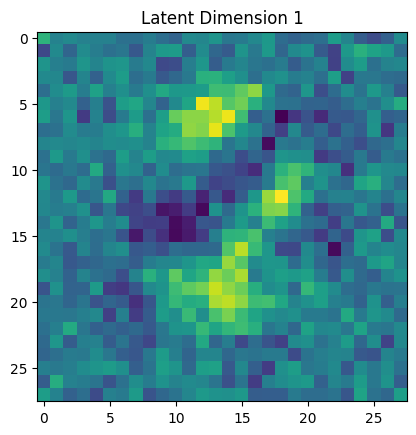

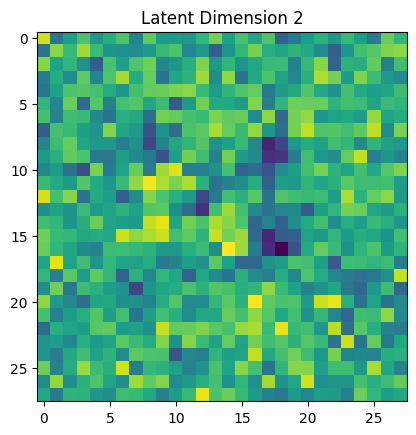

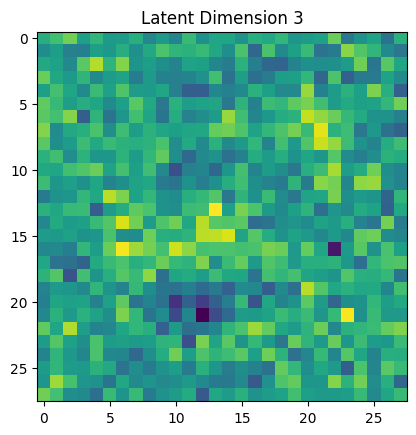

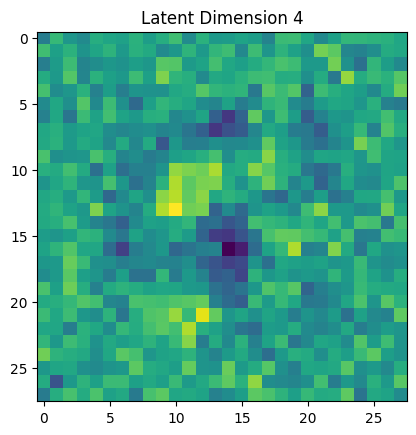

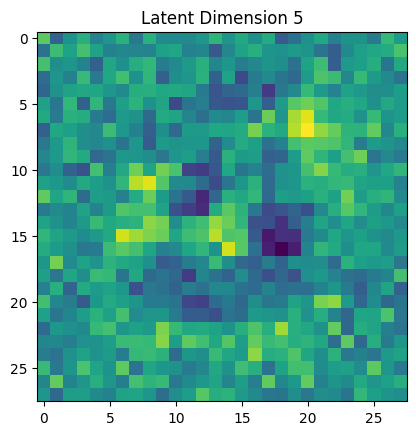

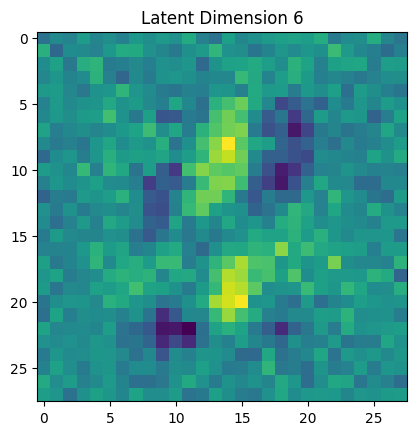

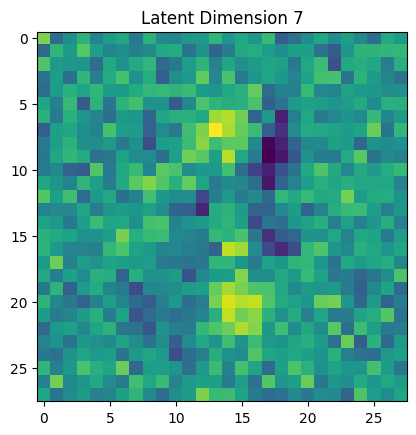

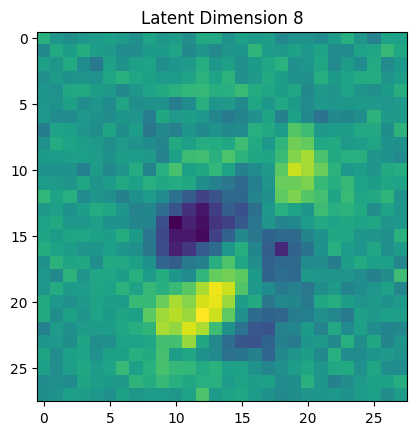

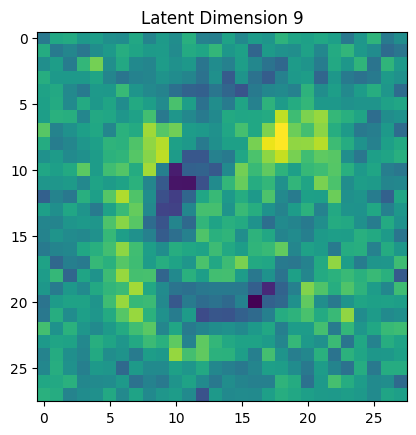

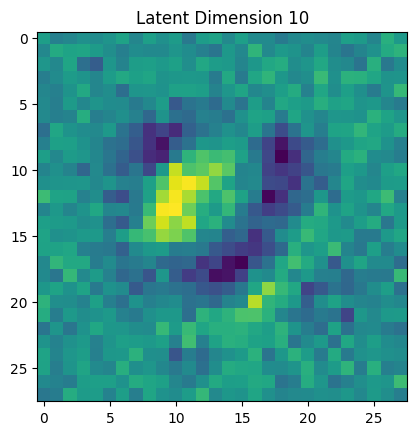

In [ ]:
#@title What Does Each Latent Dimension Represent? - Linear AE

print(l_theta[2].shape)

ld_mat = l_theta[2]

for i in range(10):
  fig, (ax1) = plt.subplots(1, 1)
  ax1.imshow(jnp.reshape(ld_mat[i], (28, 28)))
  plt.title(f"Latent Dimension {i+1}")

# Optax

In [ ]:
#@title Optimizing w/ Optax

def train_step_op(data, params, lr, opt_state):

  def l(params):
    return loss(data, params)

  grads = grad(l)(params)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state

train_step_op_jit = jax.jit(train_step_op)

def plot_steps_loss_op(n_dim, n_steps, lr, params, opt_state, col, lab):

  losses = []
  for i in range(n_steps):
    for j in range(len(x_batched)):
      params, new_opt_state = train_step_op_jit(x_batched[j],params,lr,opt_state)
      opt_state = new_opt_state
    losses.append(loss(x,params))
  plt.plot([k for k in range(n_steps)], losses, color = col, marker = 'o', label = lab)
  return params, losses

def nonlin_train_step_op(data, params, lr, opt_state):

  def l(params):
    return nonlin_loss_relu(data, params)

  grads = grad(l)(params)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state

nonlin_train_step_op_jit = jax.jit(nonlin_train_step_op)

def nonlin_plot_steps_loss_op(latent_dim, n_steps, lr, params, opt_state, col, lab):

  losses = []
  for i in range(n_steps):
    for j in range(len(x_batched)):
      params, new_opt_state = nonlin_train_step_op_jit(x_batched[j],params,lr, opt_state)
      opt_state = new_opt_state
    losses.append(nonlin_loss_relu(x,params))
  plt.plot([k for k in range(n_steps)], losses, color = col, marker = 'o', label = lab)
  return params, losses

#Nonlinear Classifier

def nonlin_train_step_supop(data, labels, params, lr, opt_state):
  def l(params):
    return nonlin_loss_sup(data, labels, params)

  grads = grad(l)(params)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state

nonlin_train_step_supop_jit = jax.jit(nonlin_train_step_supop)

def nonlin_plot_steps_loss_supop(latent_dim, n_steps, lr, theta, opt_state, col, lab):

  losses = []
  for i in range(n_steps):
    for j in range(len(x_batched)):
      theta, new_opt_state = nonlin_train_step_supop_jit(x_batched[j],x_lab_batched[j],theta,lr,opt_state)
      opt_state = new_opt_state
    losses.append(nonlin_loss_sup(x,x_lab_hot,theta))
  plt.plot([k for k in range(n_steps)], losses, color = col, marker = 'o', label = lab)
  return theta, losses

0.035956565


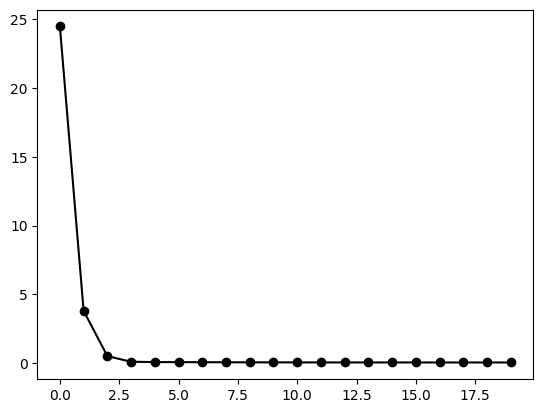

In [ ]:
#@title Loss Curve - Linear AE w/ Optax
n_dim = 10
n_steps = 20
lr = 0.001

optimizer = optax.adam(lr)
params = initialize(n_dim)
opt_state = optimizer.init(params)

op_theta, op_losses = plot_steps_loss_op(n_dim, n_steps, lr, params, opt_state,'k', '')

print(op_losses[-1])

Minimum Losses: Adam = 0.04428, Base SGD = 0.24485
Run Times: Adam = 12.904s, Base SGD = 10.997s


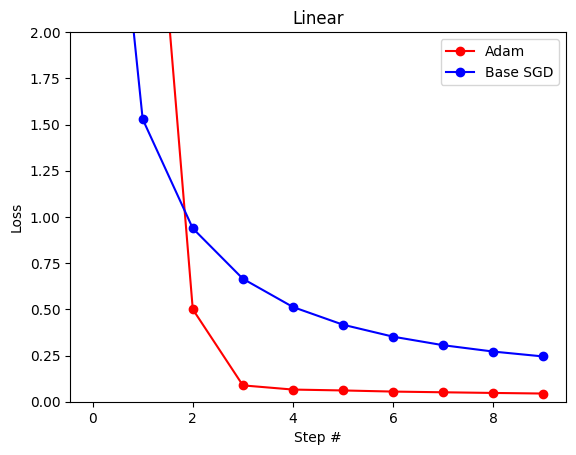

In [ ]:
#@title Loss Curve - Linear AE w/ Optax vs. No Optax
n_dim = 10
n_steps = 10
lr = 0.001

optimizer = optax.adam(lr)
params = initialize(n_dim)
opt_state = optimizer.init(params)

t0 = time.time()

op1_theta, op1_losses = plot_steps_loss_op(n_dim, n_steps, lr, params, opt_state,'red', 'Adam')

t1 = time.time()

lr = 0.03

t2 = time.time()

l1theta, l1losses = plot_steps_loss(n_dim, n_steps, lr, 'blue', 'Base SGD')

t3 = time.time()

plt.xlabel("Step #")
plt.ylabel("Loss")
plt.title("Linear")
plt.ylim(0,2)
plt.legend()

print(f"Minimum Losses: Adam = {op1_losses[-1]:.5f}, Base SGD = {l1losses[-1]:.5f}")

print(f"Run Times: Adam = {(t1 - t0):.3f}s, Base SGD = {(t3 - t2):.3f}s")

0.025365587


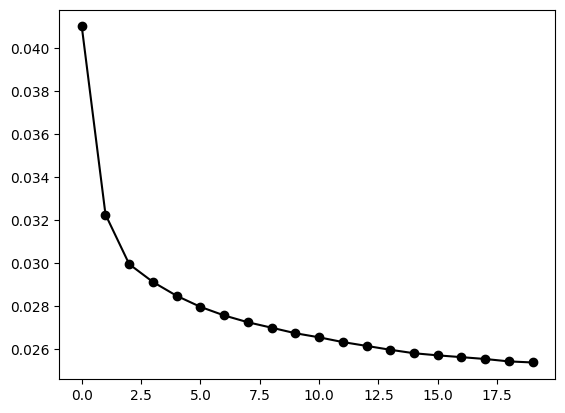

In [ ]:
#@title Loss Curve - Nonlinear AE w/ Optax
n_dim = 10
neur_dim = 100
n_steps = 20
lr = 0.001

optimizer = optax.adam(lr)
params = initialize_nl(n_dim, neur_dim)
opt_state = optimizer.init(params)

nop_theta, nop_losses = nonlin_plot_steps_loss_op(n_dim, n_steps, lr, params, opt_state,'k', '')

print(nop_losses[-1])

Minimum Losses: Adam = 0.02673, Base SGD = 0.06719
Run Times: Adam = 51.188s, Base SGD = 39.847s


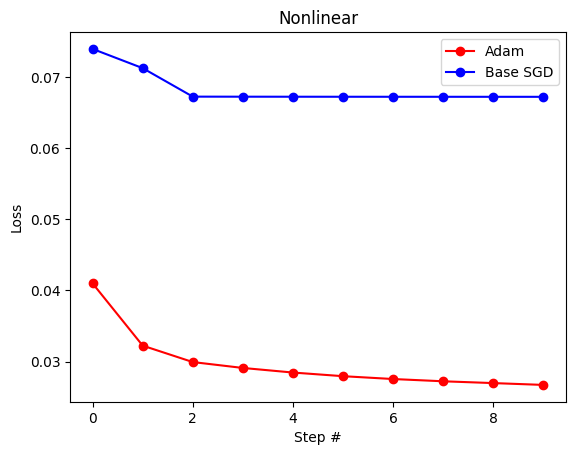

In [ ]:
#@title Loss Curve - Nonlinear AE w/ Optax vs. No Optax
n_dim = 10
neur_dim = 100
n_steps = 10
lr = 0.001

optimizer = optax.adam(lr)
params = initialize_nl(n_dim, neur_dim)
opt_state = optimizer.init(params)

t0 = time.time()

nop1_theta, nop1_losses = nonlin_plot_steps_loss_op(n_dim, n_steps, lr, params, opt_state,'red', 'Adam')

t1 = time.time()

lr = 0.03

t2 = time.time()

nl1theta, nl1losses = nonlin_plot_steps_loss_relu(n_dim, n_steps, lr, neur_dim, 'blue', 'Base SGD')

t3 = time.time()

plt.xlabel("Step #")
plt.ylabel("Loss")
plt.title("Nonlinear")
plt.legend()

print(f"Minimum Losses: Adam = {nop1_losses[-1]:.5f}, Base SGD = {nl1losses[-1]:.5f}")

print(f"Run Times: Adam = {(t1 - t0):.3f}s, Base SGD = {(t3 - t2):.3f}s")

# Interpolation

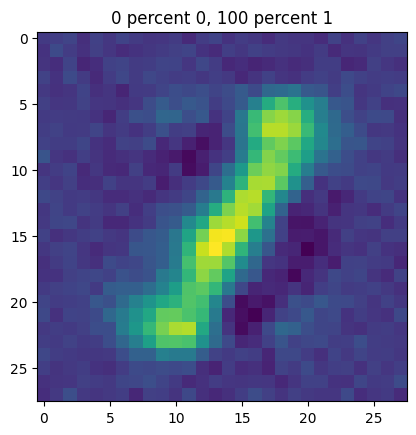

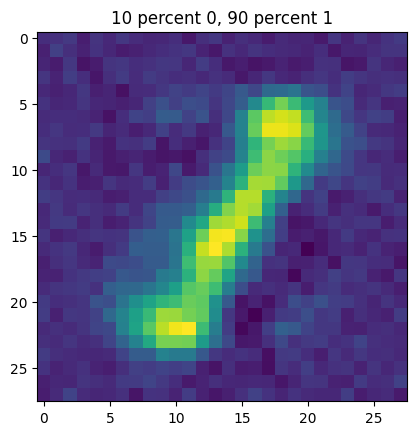

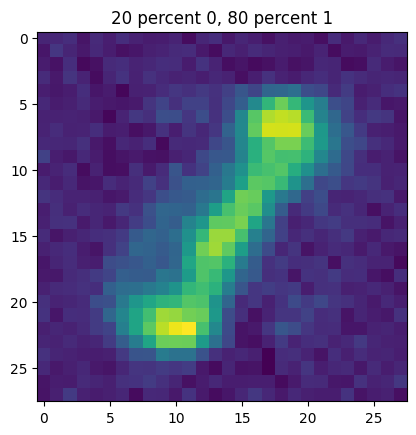

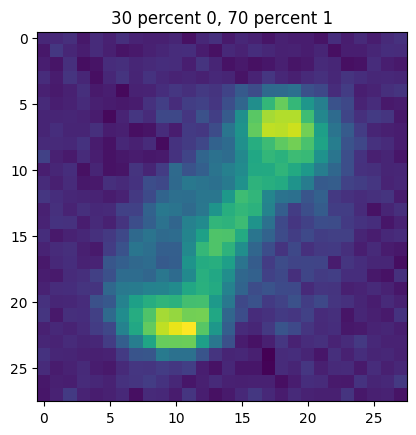

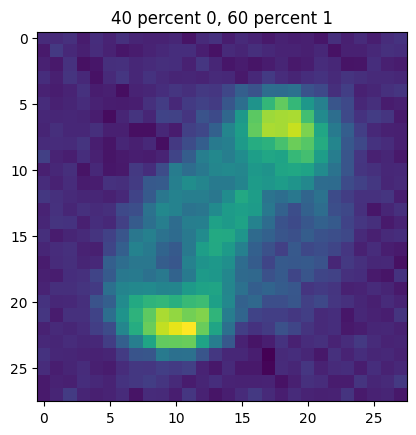

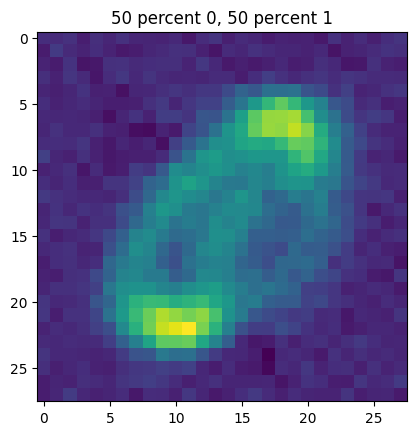

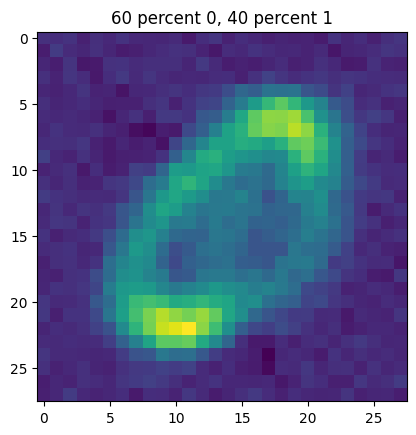

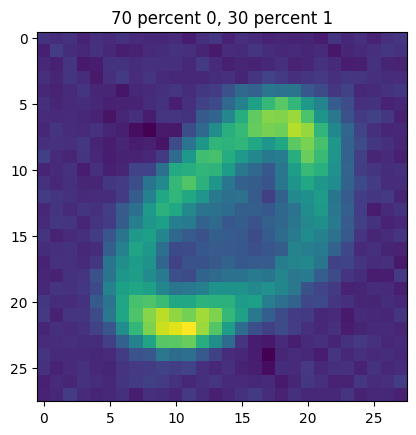

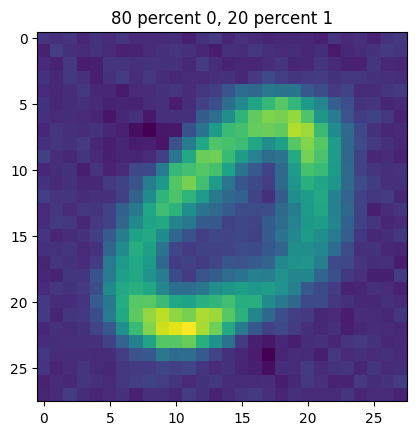

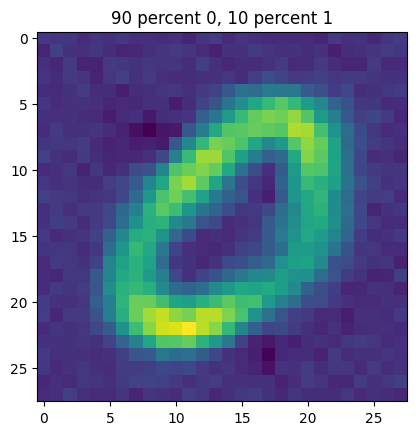

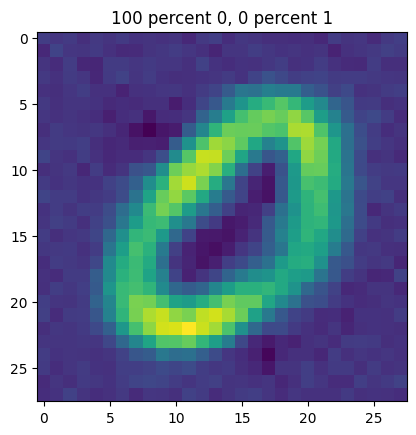

In [ ]:

#@title Interpolation Between Digits - Linear
#index 1 is a 0, index 3 is a 1

z0 = x[1] @ l_theta[0] + l_theta[1]
z1 = x[3] @ l_theta[0] + l_theta[1]

for i in range(11):
  fig, (ax1) = plt.subplots(1, 1)

  zero_perc = i * 0.1
  one_perc = 1. - zero_perc

  z = zero_perc * z0 + one_perc * z1
  x_hat = z @ l_theta[2] + l_theta[3]

  ax1.imshow(jnp.reshape(x_hat, (28, 28)))
  plt.title(f"{int(100 * zero_perc)} percent 0, {int(np.ceil(100 * one_perc))} percent 1")

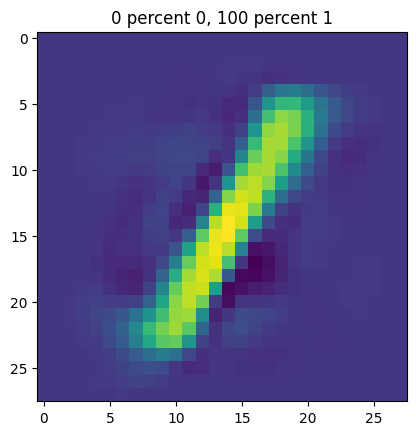

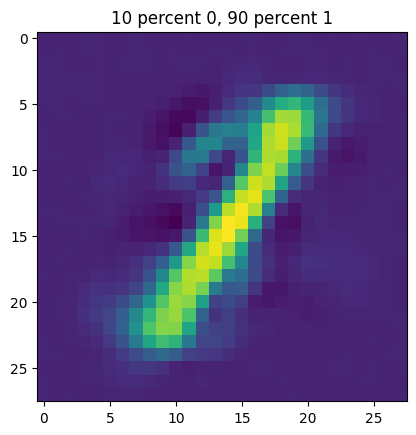

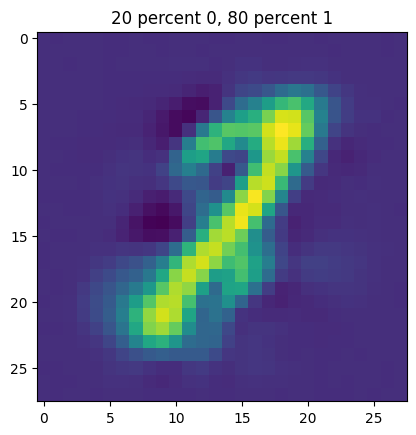

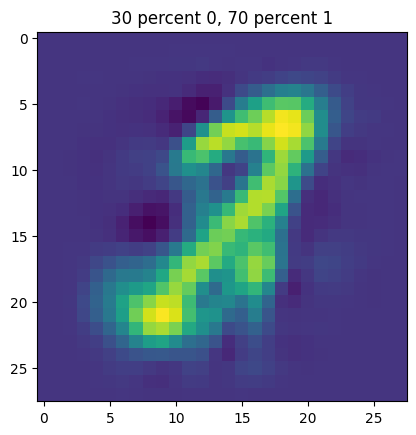

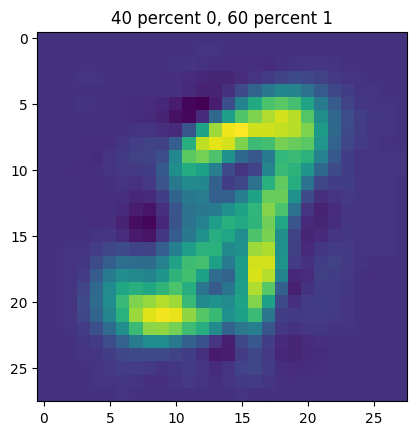

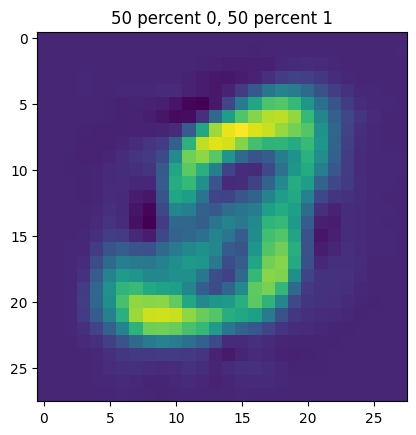

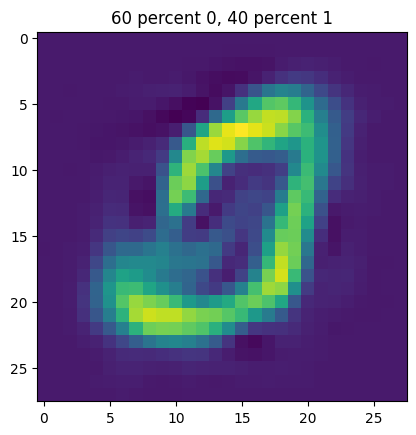

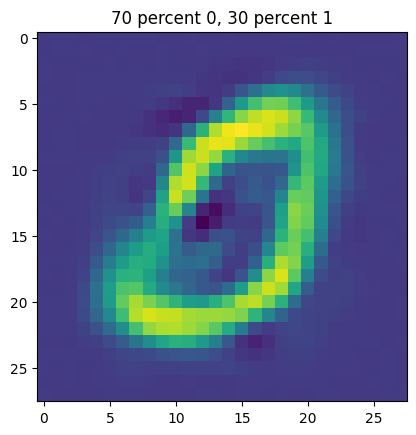

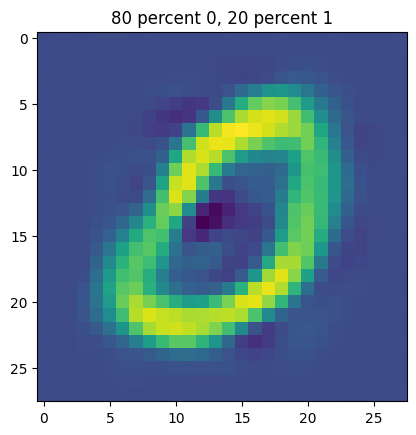

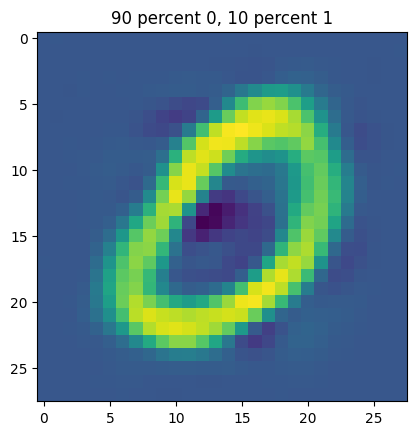

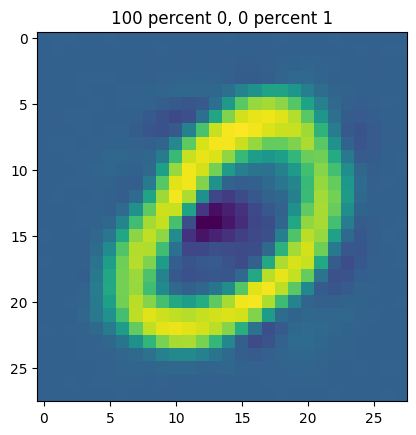

In [ ]:
#@title Interpolation Between Digits - Nonlinear

params = n_theta

z0_1 = jax.nn.relu(x[1] @ params[0] + params[1])
z0 = z0_1 @ params[2] + params[3]

z1_1 = jax.nn.relu(x[3] @ params[0] + params[1])
z1 = z1_1 @ params[2] + params[3]


for i in range(11):
  fig, (ax1) = plt.subplots(1, 1)

  zero_perc = i * 0.1
  one_perc = 1. - zero_perc

  z = zero_perc * z0 + one_perc * z1

  z_1 = jax.nn.relu(z @ params[4] + params[5])
  x_hat = jax.nn.tanh(z_1 @ params[6] + params[7])

  ax1.imshow(jnp.reshape(x_hat, (28, 28)))
  plt.title(f"{int(100 * zero_perc)} percent 0, {int(np.ceil(100 * one_perc))} percent 1")

'\nfor i in range(11):\n  fig, (ax1, ax2) = plt.subplots(1, 2)\n\n  n_zero_perc = i * 0.1\n  n_one_perc = 1. - n_zero_perc\n\n  n_z = n_zero_perc * n_z0 + n_one_perc * n_z1\n  n_x_hat = n_z @ op_theta[2] + op_theta[3]\n\n  ax2.imshow(jnp.reshape(x_hat, (28, 28)))\n  plt.title(f"{int(100 * zero_perc)} percent 0, {int(np.ceil(100 * one_perc))} percent 1")\n  '

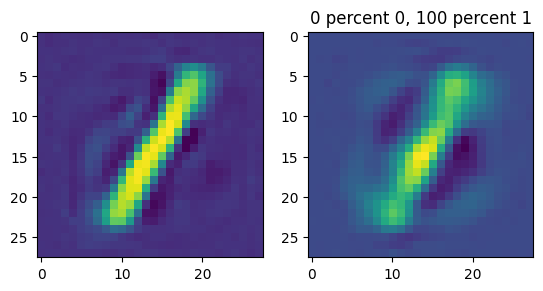

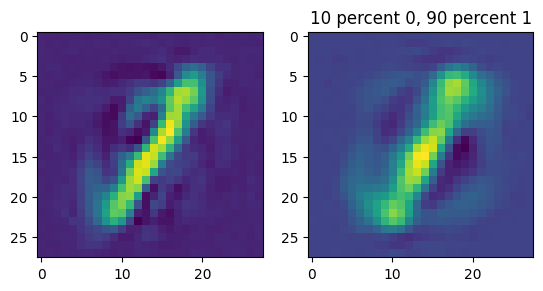

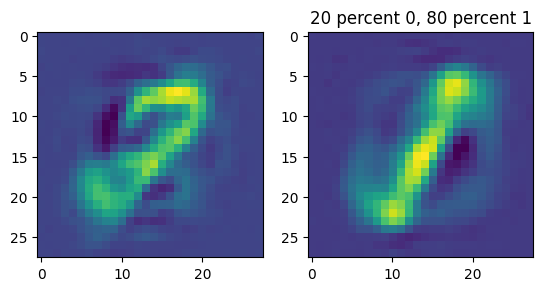

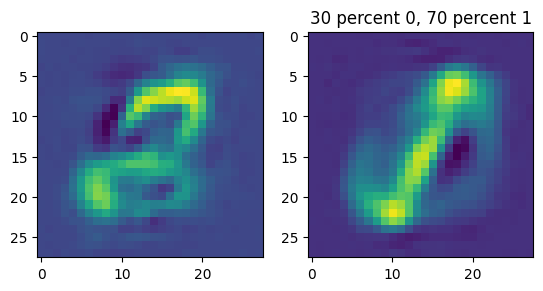

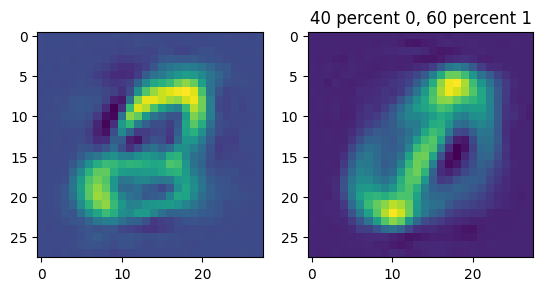

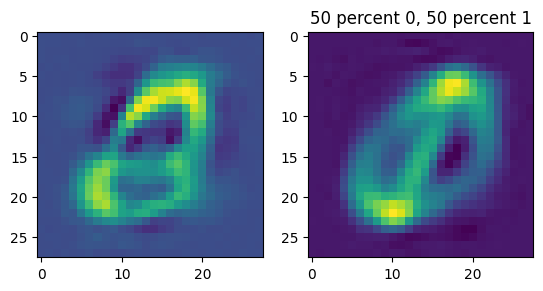

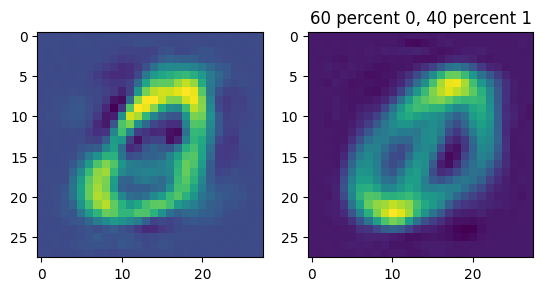

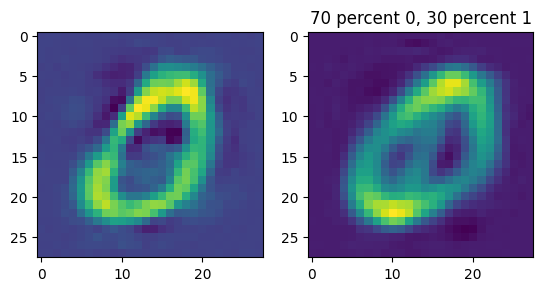

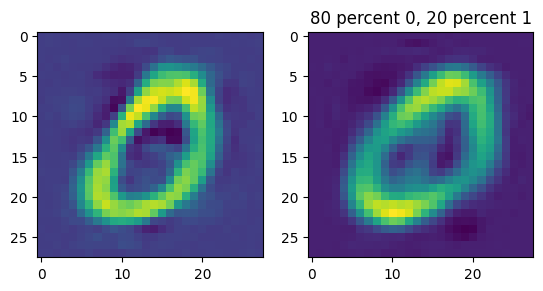

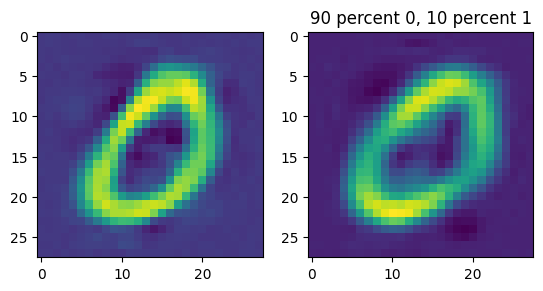

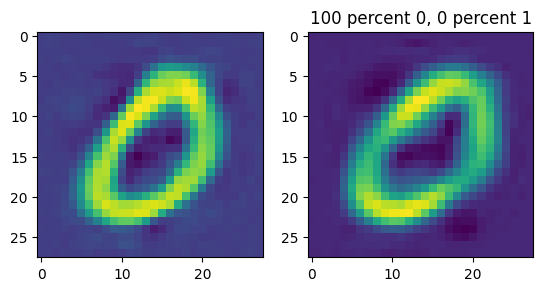

In [ ]:
#@title Interpolation Between Digits - Linear vs. Nonlinear

params = nop_theta

z0_1 = jax.nn.relu(x[1] @ params[0] + params[1])
z0 = z0_1 @ params[2] + params[3]

z1_1 = jax.nn.relu(x[3] @ params[0] + params[1])
z1 = z1_1 @ params[2] + params[3]

n_z0 = x[1] @ op_theta[0] + op_theta[1]
n_z1 = x[3] @ op_theta[0] + op_theta[1]

for i in range(11):

  fig, (ax1, ax2) = plt.subplots(1, 2)

  zero_perc = i * 0.1
  one_perc = 1. - zero_perc

  z = zero_perc * z0 + one_perc * z1

  z_1 = jax.nn.relu(z @ params[4] + params[5])
  x_hat = jax.nn.tanh(z_1 @ params[6] + params[7])

  ax1.imshow(jnp.reshape(x_hat, (28, 28)))
  plt.title(f"{int(100 * zero_perc)} percent 0, {int(np.ceil(100 * one_perc))} percent 1")

  n_zero_perc = i * 0.1
  n_one_perc = 1. - n_zero_perc

  n_z = n_zero_perc * n_z0 + n_one_perc * n_z1
  n_x_hat = n_z @ op_theta[2] + op_theta[3]

  ax2.imshow(jnp.reshape(n_x_hat, (28, 28)))
  plt.title(f"{int(100 * n_zero_perc)} percent 0, {int(np.ceil(100 * n_one_perc))} percent 1")

'''
for i in range(11):
  fig, (ax1, ax2) = plt.subplots(1, 2)

  n_zero_perc = i * 0.1
  n_one_perc = 1. - n_zero_perc

  n_z = n_zero_perc * n_z0 + n_one_perc * n_z1
  n_x_hat = n_z @ op_theta[2] + op_theta[3]

  ax2.imshow(jnp.reshape(x_hat, (28, 28)))
  plt.title(f"{int(100 * zero_perc)} percent 0, {int(np.ceil(100 * one_perc))} percent 1")
  '''

# PCA Comparisons & Image Reconstruction



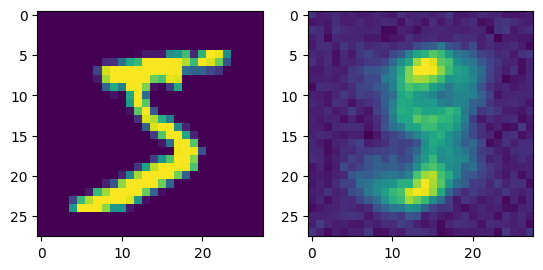

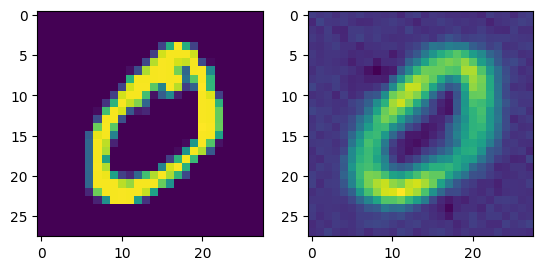

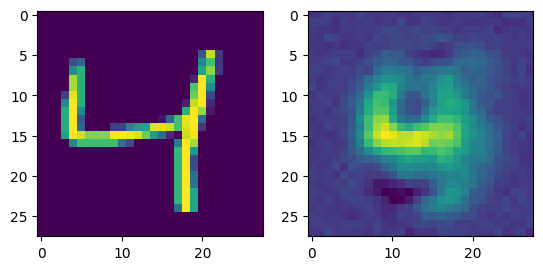

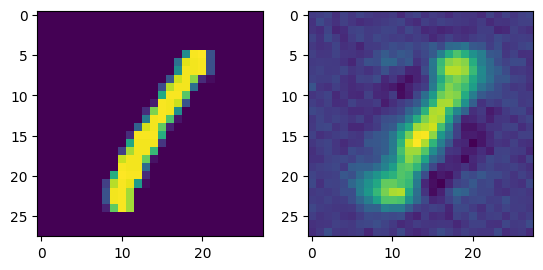

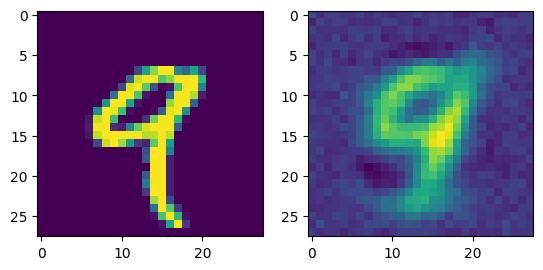

In [ ]:
#@title AE Image Reconstruction

for n in range(5):
  z = x[n] @ l_theta[0] + l_theta[1]
  x_hat = z @ l_theta[2] + l_theta[3]

  test_img = jnp.reshape(x_hat,(28,28))
  real_img = jnp.reshape(x[n], (28,28))

  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(real_img)
  ax2.imshow(test_img)

#fig = plt.figure()
#gs = fig.add_gridspec(5, 2)
#(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10) = gs.subplots(sharex='col', sharey='row')

#k = jnp.arange()

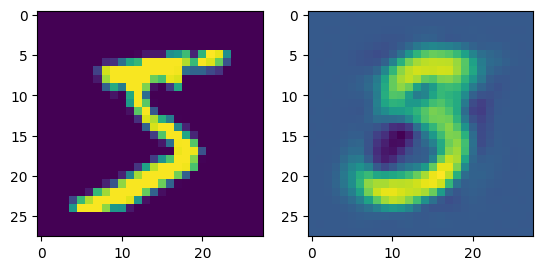

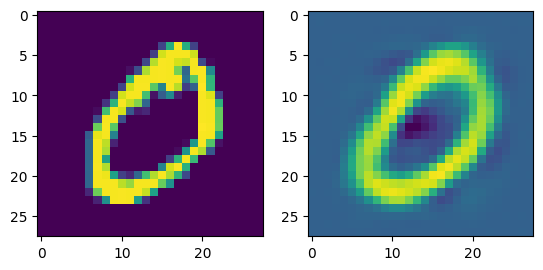

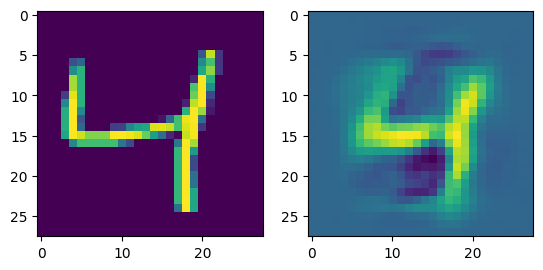

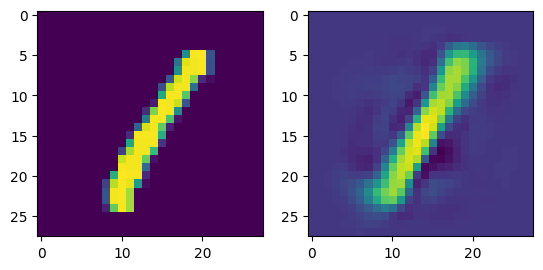

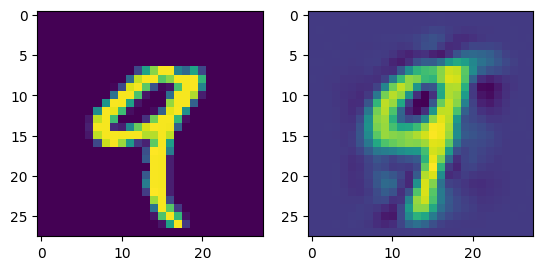

In [ ]:
#@title Nonlinear AE Image Reconstruction

params = theta

for n in range(5):
  z1 = jax.nn.relu(x[n] @ params[0] + params[1])
  z = z1 @ params[2] + params[3]
  z2 = jax.nn.relu(z @ params[4] + params[5])
  x_hat = jax.nn.tanh(z2 @ params[6] + params[7])

  test_img = jnp.reshape(x_hat,(28,28))
  real_img = jnp.reshape(x[n], (28,28))

  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(real_img)
  ax2.imshow(test_img)

In [ ]:
#@title Comparing Results to SKLearn PCA Library
n_pcs = 10

pca = PCA(n_components = n_pcs)

z_pca = pca.fit_transform(x)

print(f"% of Variance explained by the first {n_pcs} PCs: {pca.explained_variance_ratio_}")

x_hat_pca = pca.inverse_transform(z_pca)

def loss_pca(x, x_hat):
  return jnp.mean((x - x_hat)**2)

print(f"MSE Loss w/ PCA using {n_pcs} PCs: {loss_pca(x, x_hat_pca)}")

% of Variance explained by the first 10 PCs: [0.09704664 0.07095924 0.06169089 0.05389419 0.04868797 0.04312231
 0.03271928 0.0288389  0.02762029 0.02356981]
MSE Loss w/ PCA using 10 PCs: 0.034422617405653


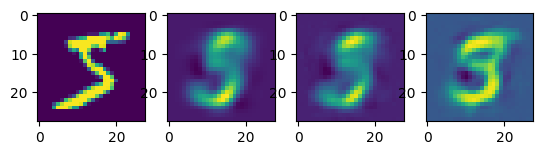

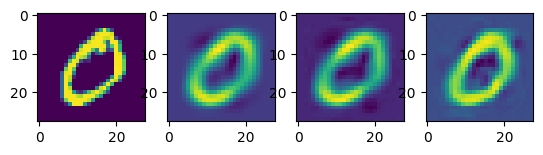

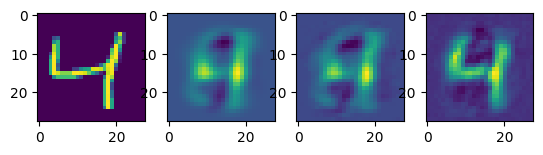

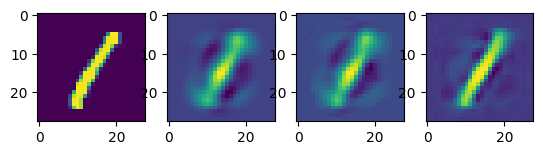

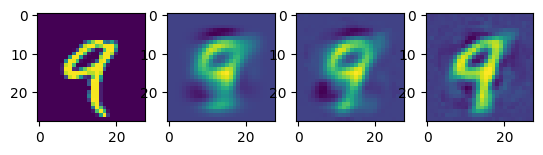

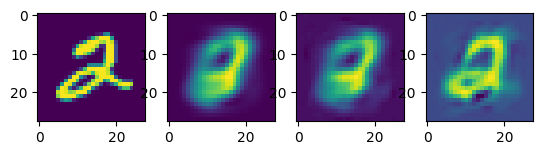

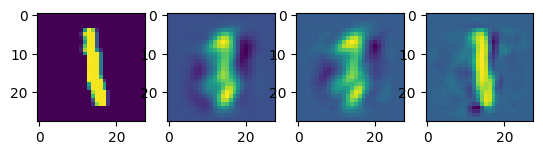

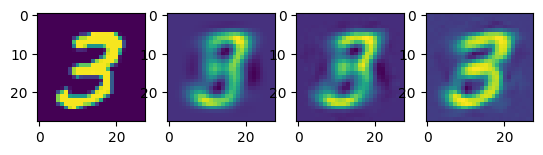

In [ ]:
#@title PCA Image Reconstruction
#real_img = jnp.reshape(x[0], (28,28))
#test_img = jnp.reshape(x_hat_pca[0], (28,28))

#fig, (ax1, ax2) = plt.subplots(1, 2)
#ax1.imshow(real_img)
#ax2.imshow(test_img)

params = op_theta
z = x @ params[0] + params[1]
x_hat_lin = z @ params[2] + params[3]

params = nop_theta
z1 = jax.nn.relu(x @ params[0] + params[1])
z = z1 @ params[2] + params[3]
z2 = jax.nn.relu(z @ params[4] + params[5])
x_hat_nonlin = jax.nn.tanh(z2 @ params[6] + params[7])

for n in range(8):
  real_img = jnp.reshape(x[n], (28,28))
  pca_img = jnp.reshape(x_hat_pca[n], (28,28))
  lin_img = jnp.reshape(x_hat_lin[n], (28,28))
  nonlin_img = jnp.reshape(x_hat_nonlin[n], (28,28))


  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
  ax1.imshow(real_img)
  ax2.imshow(pca_img)
  ax3.imshow(lin_img)
  ax4.imshow(nonlin_img)


In [ ]:
#@title PCA vs. Linear AE Image Reconstructions

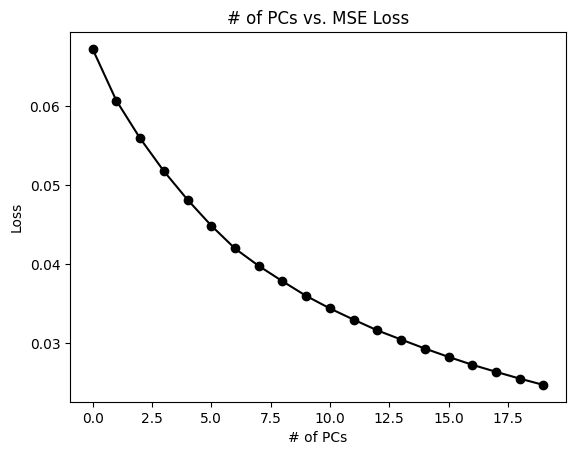

In [ ]:
#@title Num. of PCs vs. MSE Loss
plt.figure()
plt.title("# of PCs vs. MSE Loss")
plt.xlabel("# of PCs")
plt.ylabel("Loss")
losses = []
for i in range(20):
  pca = PCA(n_components = i)

  z_pca = pca.fit_transform(x)

  x_hat_pca = pca.inverse_transform(z_pca)

  losses.append(loss_pca(x, x_hat_pca))

plt.plot([j for j in range(20)], losses, color = 'k', marker = 'o')
plt.show()

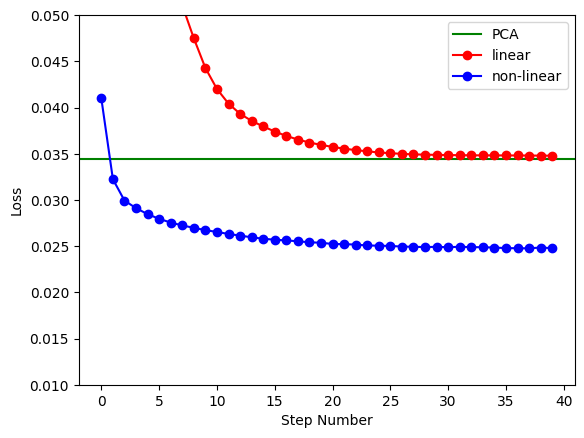

Minimum Losses: Linear = 0.03479, Nonlinear = 0.02478, PCA = 0.03442


In [ ]:
#@title Linear AE vs. Nonlinear AE vs. PCA
plt.figure()

plt.axhline(y = 0.03442, color = 'green', linestyle = '-', label = 'PCA')

n_dim = 10
n_steps = 40
lr = 0.001

optimizer = optax.adam(lr)
params = initialize(n_dim)
opt_state = optimizer.init(params)

op_theta, op_losses = plot_steps_loss_op(n_dim, n_steps, lr, params, opt_state,'red', 'linear')

optimizer = optax.adam(lr)
params = initialize_nl(n_dim, neur_dim)
opt_state = optimizer.init(params)

nop_theta, nop_losses = nonlin_plot_steps_loss_op(n_dim, n_steps, lr, params, opt_state,'blue', 'non-linear')

plt.ylim(0.01, 0.05)
plt.xlabel("Step Number")
plt.ylabel("Loss")
plt.legend()
plt.show()

print(f"Minimum Losses: Linear = {op_losses[-1]:.5f}, Nonlinear = {nop_losses[-1]:.5f}, PCA = 0.03442")

0.048122607


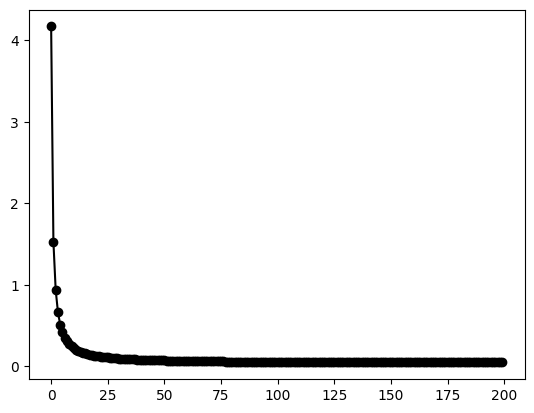

In [ ]:
test_theta, test_loss = plot_steps_loss(10, n_steps, lr, 'k','')
print(test_loss[-1])

In [ ]:
#@title Non-Linear AE (Mulit-Layer Perceptron) from SKLearn
from sklearn.neural_network import MLPRegressor

# Encoder structure
n_encoder1 = 500
n_encoder2 = 300

n_latent = 10

# Decoder structure
n_decoder2 = 300
n_decoder1 = 500

theta = initialize(10)

reg = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1),
                   activation = 'tanh',
                   learning_rate_init = 0.0001,
                   max_iter = 5,
                   verbose = True)

reg.fit(x, x)

Iteration 1, loss = 0.02674994
Iteration 2, loss = 0.01823904
Iteration 3, loss = 0.01791285
Iteration 4, loss = 0.01783841
Iteration 5, loss = 0.01779976
MLPRegressor(activation='tanh', hidden_layer_sizes=(500, 300, 10, 300, 500),
             learning_rate_init=0.0001, max_iter=5, verbose=True)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


0.034570806


<Figure size 640x480 with 0 Axes>

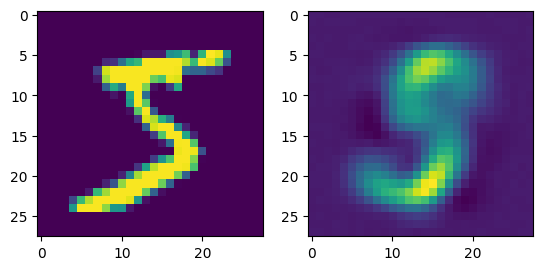

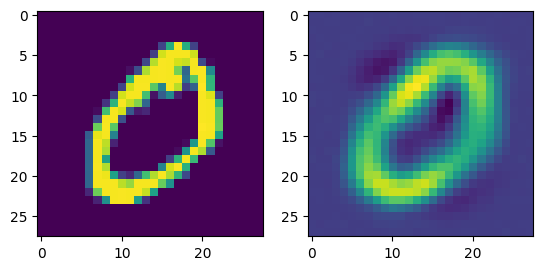

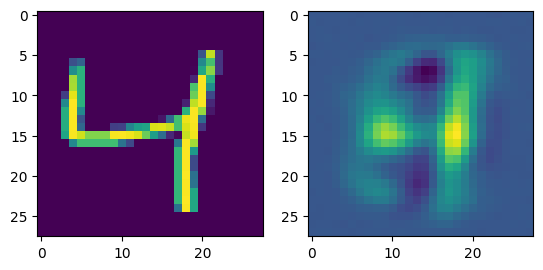

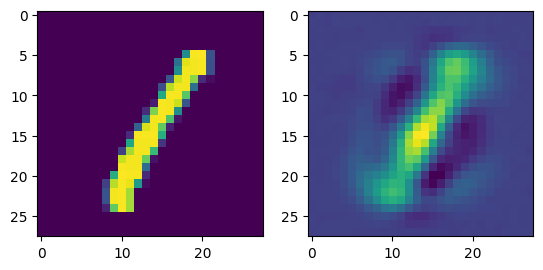

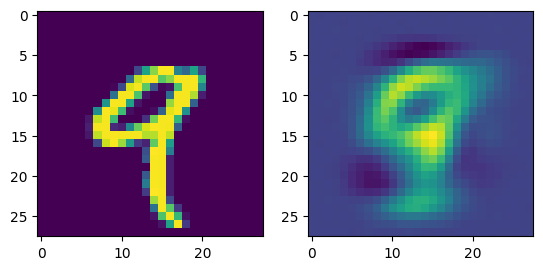

In [ ]:
#@title SKLearn Non-Linear AE Image Reconstruction
plt.figure()

print(f"Loss: {loss_pca(x, reg.predict(x))}")

for n in range(5):
  x_rec = reg.predict(jnp.reshape(x[n], (1, -1)))
  real_img = jnp.reshape(x[n], (28,28))
  test_img = jnp.reshape(x_rec, (28,28))

  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(real_img)
  ax2.imshow(test_img)

# Supervised AEs

In [ ]:
#@title Classifier (Supervised AE)

#Linear
latent_dim = 10
data_dim = 784

def initialize_sup(latent_dim):
  W_1 = jr.normal(jr.PRNGKey(0), (data_dim, latent_dim))
  b_1 = jr.normal(jr.PRNGKey(1), (latent_dim,))
  W_2 = jr.normal(jr.PRNGKey(2), (latent_dim, data_dim))
  b_2 = jr.normal(jr.PRNGKey(3), (data_dim,))
  W_3 = jr.normal(jr.PRNGKey(4), (latent_dim, 10))
  b_3 = jr.normal(jr.PRNGKey(5), (10,))
  return([W_1, b_1, W_2, b_2, W_3, b_3])

def loss_sup(data, labels, params):
  def transform(data):
    z = data @ params[0] + params[1]
    x_hat = z @ params[2] + params[3]
    y_hat = z @ params[4] + params[5]
    return x_hat, y_hat
  x_hat, y_hat = vmap(transform)(data)
  return ( jnp.mean((data - x_hat) ** 2) + jnp.mean((labels - y_hat) ** 2) )

def train_step_sup(data, labels, params, lr):
  def l(params):
    return loss_sup(data, labels, params)

  g = grad(l)(params)

  for i in range(len(params)):
    params[i] -= g[i] * lr

  return params

train_step_sup_jit = jax.jit(train_step_sup)

def plot_steps_loss_sup(n_dim, n_steps, lr, col, lab):
  theta = initialize_sup(n_dim)
  losses = []
  for i in range(n_steps):
    for j in range(len(x_batched)):
      theta = train_step_sup_jit(x_batched[j],x_lab_batched[j],theta,lr)
    losses.append(loss_sup(x,x_lab_hot,theta))
  plt.plot([k for k in range(n_steps)], losses, color = col, marker = 'o', label = lab)
  return theta, losses

#Nonlinear
def initialize_nl_sup(latent_dim, neur_dim):
  #encoding
  W_1 = jr.normal(jr.PRNGKey(0), (data_dim, neur_dim)) / neur_dim
  b_1 = jr.normal(jr.PRNGKey(1), (neur_dim,))
  W_2 = jr.normal(jr.PRNGKey(2), (neur_dim, latent_dim)) / neur_dim
  b_2 = jr.normal(jr.PRNGKey(3), (latent_dim,))

  #decoding - reconstruction
  W_3 = jr.normal(jr.PRNGKey(4), (latent_dim, neur_dim)) / neur_dim
  b_3 = jr.normal(jr.PRNGKey(5), (neur_dim,))
  W_4 = jr.normal(jr.PRNGKey(6), (neur_dim, data_dim)) / neur_dim
  b_4 = jr.normal(jr.PRNGKey(7), (data_dim,))

  #decoding - classification
  W_5 = jr.normal(jr.PRNGKey(4), (latent_dim, neur_dim)) / neur_dim
  b_5 = jr.normal(jr.PRNGKey(5), (neur_dim,))
  W_6 = jr.normal(jr.PRNGKey(6), (neur_dim, 10)) / neur_dim
  b_6 = jr.normal(jr.PRNGKey(7), (10,))
  return([W_1, b_1, W_2, b_2, W_3, b_3, W_4, b_4, W_5, b_5, W_6, b_6])

def nonlin_loss_sup(data, labels, params):
  def nonlin_transform(data):
    z1 = jax.nn.relu(data @ params[0] + params[1])
    z = z1 @ params[2] + params[3]
    z2 = jax.nn.relu(z @ params[4] + params[5])
    x_hat = jax.nn.tanh(z2 @ params[6] + params[7])

    z3 = jax.nn.relu(z @ params[8] + params[9])
    y_hat = jax.nn.tanh(z3 @ params[10] + params[11])
    return x_hat, y_hat
  x_hat, y_hat = vmap(nonlin_transform)(data)
  return ( jnp.mean((data - x_hat) ** 2) + jnp.mean((labels - y_hat) ** 2) )

def nonlin_train_step_sup(data, labels, params, lr):
  def l(params):
    return nonlin_loss_sup(data, labels, params)

  g = grad(l)(params)

  for i in range(len(params)):
    params[i] -= g[i] * lr

  return params

nonlin_train_step_sup_jit = jax.jit(nonlin_train_step_sup)

def nonlin_plot_steps_loss_sup(latent_dim, n_steps, lr, neur_dim, col, lab):
  theta = initialize_nl_sup(latent_dim, neur_dim)
  losses = []
  for i in range(n_steps):
    for j in range(len(x_batched)):
      theta = nonlin_train_step_sup_jit(x_batched[j],x_lab_batched[j],theta,lr)
    losses.append(nonlin_loss_sup(x,x_lab_hot,theta))
  plt.plot([k for k in range(n_steps)], losses, color = col, marker = 'o', label = lab)
  return theta, losses

Minimum Loss: 0.11304894089698792


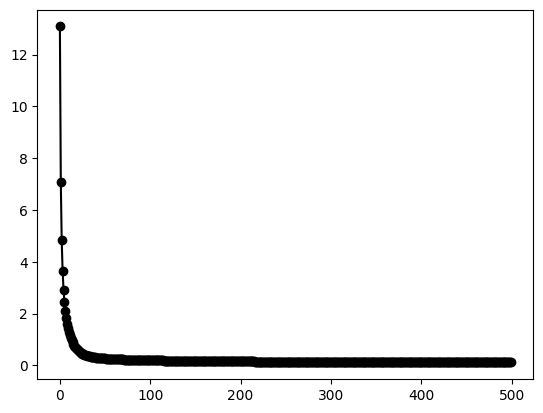

In [ ]:
#@title Loss Curve - Supervised Linear AE
n_steps = 500
n_dim = 10
lr = 0.01

s_theta, s_losses = plot_steps_loss_sup(n_dim, n_steps, lr, 'k', '')

print(f"Minimum Loss: {s_losses[-1]}")

Minimum Loss: 0.04631437733769417


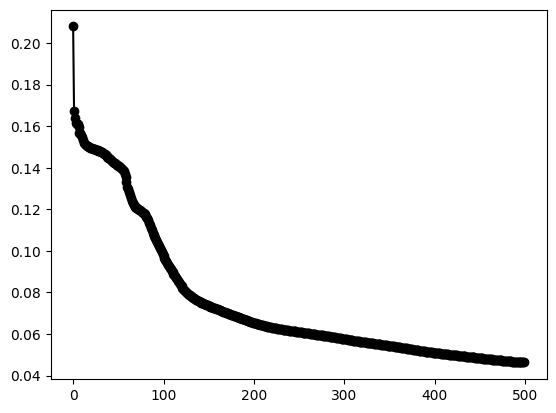

In [ ]:
#@title Loss Curve - Supervised Nonlinear AE
n_steps = 500
l_dim = 10
neur_dim = 100
lr = 0.01

sn_theta, sn_losses = nonlin_plot_steps_loss_sup(n_dim, n_steps, lr, neur_dim, 'k', '')

print(f"Minimum Loss: {sn_losses[-1]}")

Minimum Losses: Linear = 1.42626, Nonlinear = 0.15593


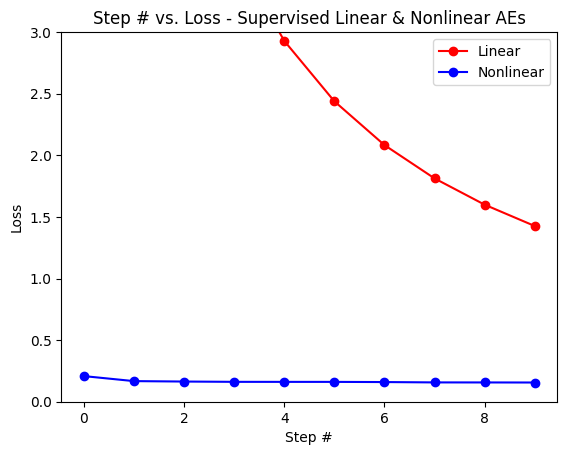

In [ ]:
n_steps = 10
l_dim = 10
neur_dim = 100
lr = 0.01

s1_theta, s1_losses = plot_steps_loss_sup(n_dim, n_steps, lr, 'red', 'Linear')

sn1_theta, sn1_losses = nonlin_plot_steps_loss_sup(n_dim, n_steps, lr, neur_dim, 'blue', 'Nonlinear')

plt.ylim(0,3)
plt.legend()
plt.title("Step # vs. Loss - Supervised Linear & Nonlinear AEs")
plt.xlabel("Step #")
plt.ylabel("Loss")

print(f"Minimum Losses: Linear = {s1_losses[-1]:.5f}, Nonlinear = {sn1_losses[-1]:.5f}")

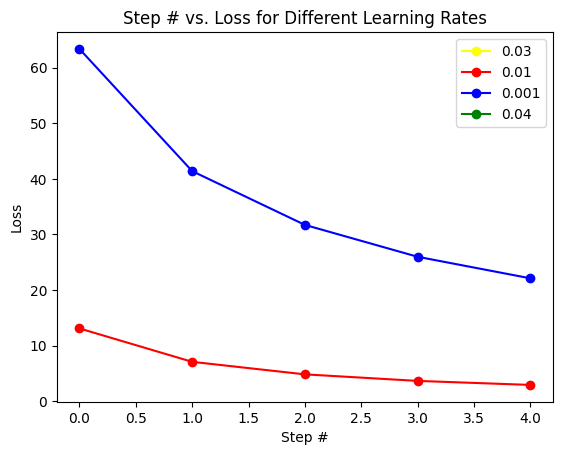

nan nan


In [ ]:
#@title Loss Curve - Supervised Linear Learning Rate Comparisons

latent_dim = 10
n_steps = 5

plt.figure()
plt.title("Step # vs. Loss for Different Learning Rates")
plt.xlabel("Step #")
plt.ylabel("Loss")

#lr of 0.03
lr = 0.03

theta1, l1 = plot_steps_loss_sup(latent_dim, n_steps, lr, 'yellow', f"{lr}")

#lr of 0.01
lr = 0.01

plot_steps_loss_sup(latent_dim, n_steps, lr, 'red', f"{lr}")

#lr of 0.001
lr = 0.001

plot_steps_loss_sup(latent_dim, n_steps, lr, 'blue', f"{lr}")

#lr of 0.0001
lr = 0.04

theta2, l2 = plot_steps_loss_sup(latent_dim, n_steps, lr, 'green', f"{lr}")

plt.legend()
plt.show()

print(l1[-1], l2[-1])

In [ ]:
#@title Classifier Accuracy

def accuracy(data, labs, params, end):
  correct = 0.
  for i in range(end):
    z = data[i] @ params[0] + params[1]
    y_hat = z @ params[4] + params[5]

    pred = jnp.where(y_hat == max(y_hat))[0][0]
    real = jnp.where(labs[i] == max(labs[i]))[0][0]

    if (pred == real):
      correct += 1

  return (correct / end)

def nonlin_accuracy(data, labs, params, end):
  correct = 0.
  for i in range(end):

    z1 = jax.nn.relu(data[i] @ params[0] + params[1])
    z = z1 @ params[2] + params[3]

    z3 = jax.nn.relu(z @ params[8] + params[9])
    y_hat = jax.nn.tanh(z3 @ params[10] + params[11])

    pred = jnp.where(y_hat == max(y_hat))[0][0]
    #print(f"Predicted: {pred}")
    real = jnp.where(labs[i] == max(labs[i]))[0][0]
    #print(f"Actual: {real}")

    if (pred == real):
      correct += 1

  return (correct / end)

print(f"Linear AE Accuracy (train data): {accuracy(x, x_lab_hot, s_theta, 1000)}")
print(f"Nonlinear AE Accuracy (train data): {nonlin_accuracy(x, x_lab_hot, sn_theta, 1000)}")

print(f"Linear AE Accuracy (test data): {accuracy(x_test, x_test_lab_hot, s_theta, 1000)}")
print(f"Nonlinear AE Accuracy (test data): {nonlin_accuracy(x_test, x_test_lab_hot, sn_theta, 1000)}")

KeyboardInterrupt: ignored

0.033628844


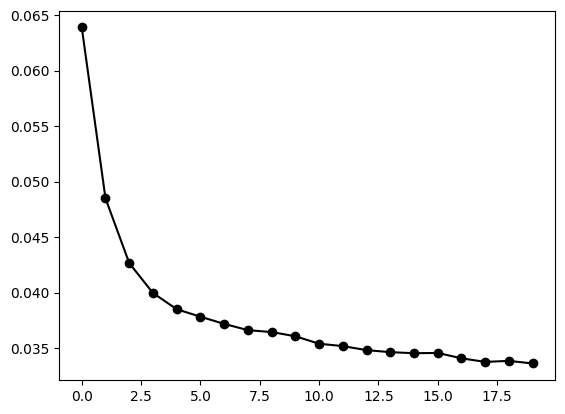

In [ ]:
#@title Loss Curve - Sup Nonlinear AE w/ Optax
n_dim = 10
neur_dim = 100
n_steps = 20
lr = 0.001

optimizer = optax.adam(lr)
params = initialize_nl_sup(n_dim, neur_dim)
opt_state = optimizer.init(params)

supop_theta, supop_losses = nonlin_plot_steps_loss_supop(n_dim, n_steps, lr, params, opt_state,'k', '')

print(supop_losses[-1])

# 2d/3d Supervised Representations & T-SNE

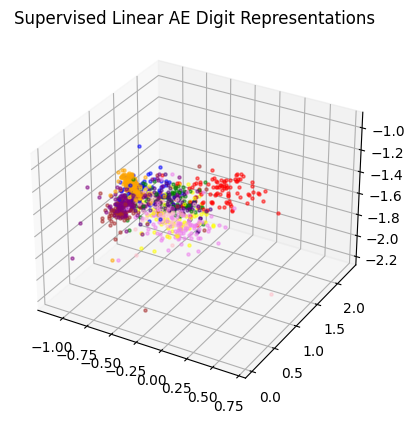

In [ ]:
#@title 3d Representation - Linear Classifer
colors = ['red','orange','yellow','green','blue','indigo','violet','purple','pink','brown']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(1000):
  z = x[i] @ s_theta[0] + s_theta[1]
  ax.scatter(z[0], z[1], z[2], marker = '.', alpha = 0.5, color = colors[x_lab[i]])

plt.title("Supervised Linear AE Digit Representations")
plt.show()

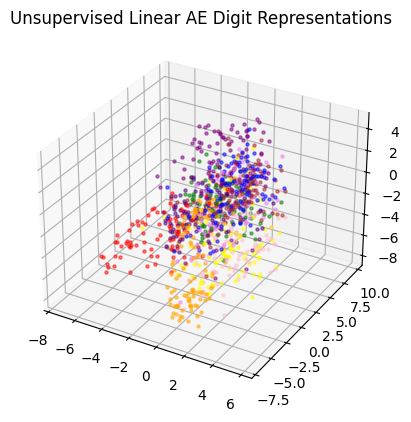

In [ ]:
#@title 3d Representation - Linear Unsup
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(1000):
  z = x[i] @ op_theta[0] + op_theta[1]
  ax.scatter(z[0], z[1], z[2], marker = '.', alpha = 0.5, color = colors[x_lab[i]])

plt.title("Unsupervised Linear AE Digit Representations")
plt.show()

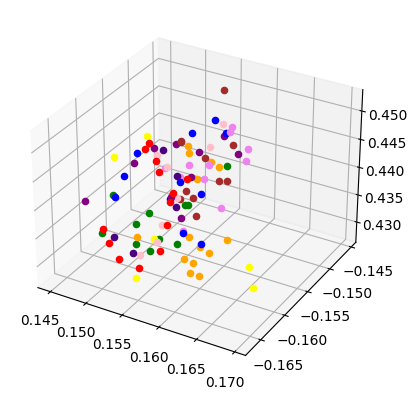

In [ ]:
#@title 3d Representation - Nonlinear Classifer
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(100):
  z1 = jax.nn.relu(x[i] @ params[0] + params[1])
  z = z1 @ params[2] + params[3]
  ax.scatter(z[0], z[1], z[2], color = colors[x_lab[i]])

plt.show()

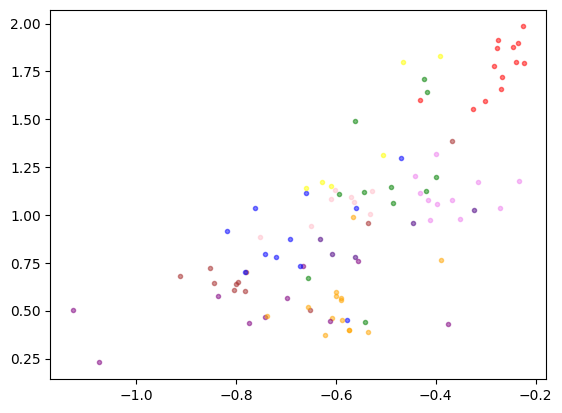

In [ ]:
#@title 2d Representation - Linear Classifer

plt.figure()

for i in range(100):
  z = x[i] @ s_theta[0] + s_theta[1]
  plt.scatter(z[0], z[1], marker = '.', alpha = 0.5, color = colors[x_lab[i]])

plt.show()

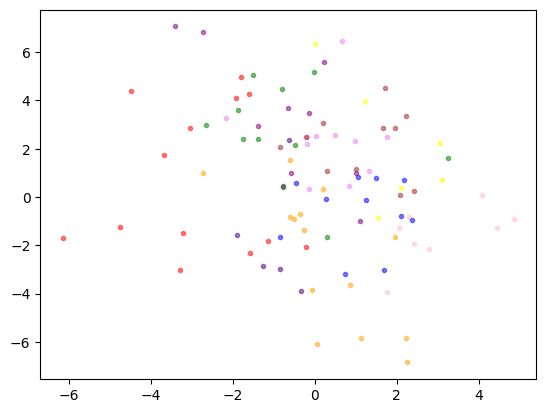

In [ ]:
#@title 2d Representation - Linear Classifer

plt.figure()

for i in range(100):
  z = x[i] @ op_theta[0] + op_theta[1]
  plt.scatter(z[0], z[1], marker = '.', alpha = 0.5, color = colors[x_lab[i]])

plt.show()

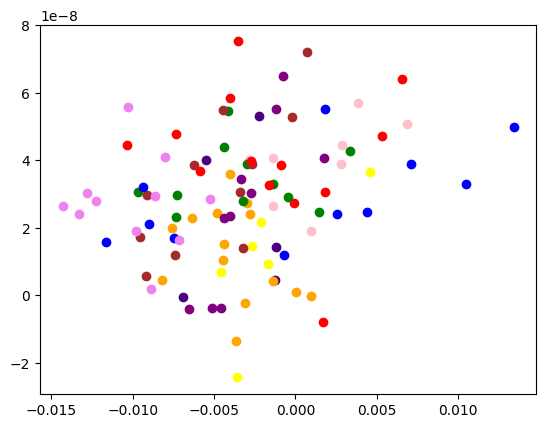

In [ ]:
#@title 2d Representation - Nonlinear Classifer
plt.figure()

for i in range(100):
  z1 = jax.nn.relu(x[i] @ params[0] + params[1])
  z = z1 @ params[2] + params[3]
  plt.scatter(z[0], z[1], color = colors[x_lab[i]])

plt.show()

In [ ]:
#@title Unupervised Linear + T-SNE - Plotly Interactive 3d

colors = ['red','orange','yellow','green','blue','indigo','violet','purple','pink','brown']

end = 1000

params = nop_theta

z1 = jax.nn.relu(x @ params[0] + params[1])
z = z1 @ params[2] + params[3]
d_color = [colors[x_lab[i]] for i in range(end)]
#print(d_color)

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(z[:end])

xs = [tsne_results[i, 0] for i in range(end)]
ys = [tsne_results[i, 1] for i in range(end)]
zs = [tsne_results[i, 2] for i in range(end)]

fig = px.scatter_3d(x = xs,y = ys,z = zs, color = d_color,
                    labels={"red": "0", "orange": "1", 'yellow': '2','green': '3','blue': '4',
                            'indigo' : '5','violet' : '6','purple' : '7','pink' : '8','brown': '9'},
                    title="Unsupervised Nonlinear 3d Representations")
fig.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.272s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.743767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.654594
[t-SNE] KL divergence after 300 iterations: 1.016404


In [ ]:
#@title Supervised Nonlin + T-SNE - Plotly Interactive 3d

colors = ['red','orange','yellow','green','blue','indigo','violet','purple','pink','brown']

end = 1000

params = supop_theta

z1 = jax.nn.relu(x @ params[0] + params[1])
z = z1 @ params[2] + params[3]
d_color = [colors[x_lab[i]] for i in range(end)]
#print(d_color)

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(z[:end])

xs = [tsne_results[i, 0] for i in range(end)]
ys = [tsne_results[i, 1] for i in range(end)]
zs = [tsne_results[i, 2] for i in range(end)]

fig = px.scatter_3d(x = xs,y = ys,z = zs, color = d_color,
                    labels={"red": "0", "orange": "1", 'yellow': '2','green': '3','blue': '4',
                            'indigo' : '5','violet' : '6','purple' : '7','pink' : '8','brown': '9'},
                    title="Unsupervised Nonlinear 3d Representations")
fig.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.104s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.654213
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.288982
[t-SNE] KL divergence after 300 iterations: 0.550553


['indigo', 'red', 'blue', 'orange', 'brown', 'yellow', 'orange', 'green', 'orange', 'blue', 'green', 'indigo', 'green', 'violet', 'orange', 'purple', 'yellow', 'pink', 'violet', 'brown', 'blue', 'red', 'brown', 'orange', 'orange', 'yellow', 'blue', 'green', 'yellow', 'purple', 'green', 'pink', 'violet', 'brown', 'red', 'indigo', 'violet', 'red', 'purple', 'violet', 'orange', 'pink', 'purple', 'brown', 'green', 'brown', 'pink', 'indigo', 'brown', 'green', 'green', 'red', 'purple', 'blue', 'brown', 'pink', 'red', 'brown', 'blue', 'orange', 'blue', 'blue', 'violet', 'red', 'blue', 'indigo', 'violet', 'orange', 'red', 'red', 'orange', 'purple', 'orange', 'violet', 'green', 'red', 'yellow', 'orange', 'orange', 'purple', 'brown', 'red', 'yellow', 'violet', 'purple', 'pink', 'green', 'brown', 'red', 'blue', 'violet', 'purple', 'blue', 'violet', 'pink', 'red', 'purple', 'pink', 'green', 'orange', 'indigo', 'purple', 'orange', 'purple', 'orange', 'orange', 'violet', 'green', 'red', 'yellow', 'b

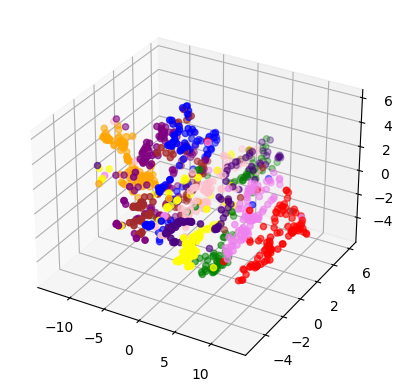

In [ ]:
#@title Visualization w/ T-SNE - Unsup Nonlin

end = 1000

params = nop_theta

z1 = jax.nn.relu(x @ params[0] + params[1])
z = z1 @ params[2] + params[3]
d_color = [colors[x_lab[i]] for i in range(end)]
print(d_color)

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(z[:end])

xs = [tsne_results[i, 0] for i in range(end)]
ys = [tsne_results[i, 1] for i in range(end)]
zs = [tsne_results[i, 2] for i in range(end)]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, color = d_color)

plt.show()

['indigo', 'red', 'blue', 'orange', 'brown', 'yellow', 'orange', 'green', 'orange', 'blue', 'green', 'indigo', 'green', 'violet', 'orange', 'purple', 'yellow', 'pink', 'violet', 'brown', 'blue', 'red', 'brown', 'orange', 'orange', 'yellow', 'blue', 'green', 'yellow', 'purple', 'green', 'pink', 'violet', 'brown', 'red', 'indigo', 'violet', 'red', 'purple', 'violet', 'orange', 'pink', 'purple', 'brown', 'green', 'brown', 'pink', 'indigo', 'brown', 'green', 'green', 'red', 'purple', 'blue', 'brown', 'pink', 'red', 'brown', 'blue', 'orange', 'blue', 'blue', 'violet', 'red', 'blue', 'indigo', 'violet', 'orange', 'red', 'red', 'orange', 'purple', 'orange', 'violet', 'green', 'red', 'yellow', 'orange', 'orange', 'purple', 'brown', 'red', 'yellow', 'violet', 'purple', 'pink', 'green', 'brown', 'red', 'blue', 'violet', 'purple', 'blue', 'violet', 'pink', 'red', 'purple', 'pink', 'green', 'orange', 'indigo', 'purple', 'orange', 'purple', 'orange', 'orange', 'violet', 'green', 'red', 'yellow', 'b

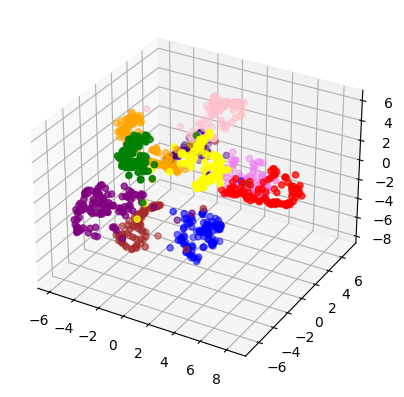

In [ ]:
#@title Visualization w/ T-SNE - Sup Nonlin
from sklearn.manifold import TSNE

end = 1000

params = supop_theta

z1 = jax.nn.relu(x @ params[0] + params[1])
z = z1 @ params[2] + params[3]
d_color = [colors[x_lab[i]] for i in range(end)]
print(d_color)

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(z[:end])

xs = [tsne_results[i, 0] for i in range(end)]
ys = [tsne_results[i, 1] for i in range(end)]
zs = [tsne_results[i, 2] for i in range(end)]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, color = d_color)

plt.show()

# Image Generation

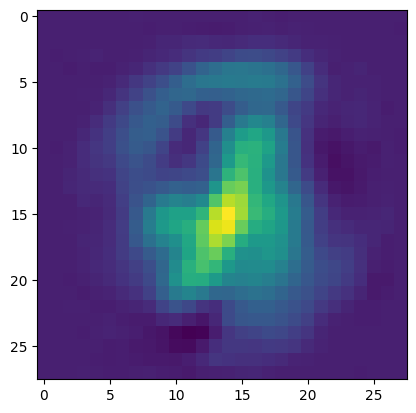

In [ ]:
#@title Random Digit Generation - Linear

latent_dim = 10
neur_dim = 100

params = op_theta

z = jr.normal(jr.PRNGKey(14), (1, latent_dim))
x_hat = z @ params[2] + params[3]

'''
z2 = jax.nn.relu(z @ params[4] + params[5])
x_hat = jax.nn.tanh(z2 @ params[6] + params[7])
'''

plt.imshow(x_hat.reshape(28,28))

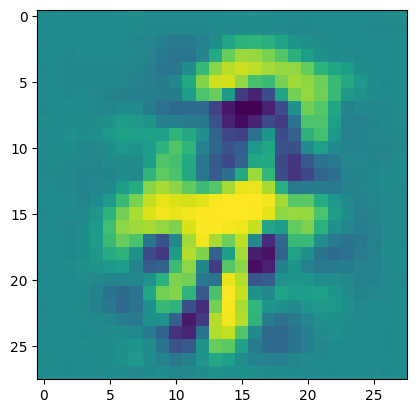

In [ ]:
#@title Random Digit Generation - Nonlinear

latent_dim = 10
neur_dim = 100

params = nop_theta

z = jr.normal(jr.PRNGKey(5), (1, latent_dim))
z2 = jax.nn.relu(z @ params[4] + params[5])
x_hat = jax.nn.tanh(z2 @ params[6] + params[7])

plt.imshow(x_hat.reshape(28,28))